#Import and config

In [ ]:
import random
import numpy as np
import pandas as pd
import time
import os
import json
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,classification_report , accuracy_score


from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Homework5_dataset/0788_c6s2_120318_01.jpg  
  inflating: Homework5_dataset/0788_c6s2_120318_05.jpg  
  inflating: Homework5_dataset/0788_c6s2_120368_01.jpg  
  inflating: Homework5_dataset/0788_c6s2_120418_01.jpg  
  inflating: Homework5_dataset/0788_c6s2_120443_01.jpg  
  inflating: Homework5_dataset/0792_c1s4_026706_01.jpg  
  inflating: Homework5_dataset/0792_c1s4_026731_01.jpg  
  inflating: Homework5_dataset/0792_c1s4_026881_02.jpg  
  inflating: Homework5_dataset/0792_c2s2_084057_03.jpg  
  inflating: Homework5_dataset/0792_c2s2_084157_03.jpg  
  inflating: Homework5_dataset/0792_c3s2_087428_01.jpg  
  inflating: Homework5_dataset/0792_c3s2_087503_02.jpg  
  inflating: Homework5_dataset/0792_c3s2_087528_01.jpg  
  inflating: Homework5_dataset/0792_c4s4_027135_01.jpg  
  inflating: Homework5_dataset/0792_c4s4_027160_02.jpg  
  inflating: Homework5_dataset/0792_c4s4_027535_01.jpg  
  inflating: Homework5_dataset/0792_c

In [ ]:
root_dir = '/content/drive/MyDrive/project/'
model_config_dir = os.path.join(root_dir , 'config')
model_fig_dir = os.path.join(root_dir , 'fig')
data_dir = 'Homework5_dataset'

# Utils and hyperparameters

In [ ]:
IMG_SIZE = 224
batch_sizes = {'train': 32, 'val':32 , "test":32}

In [ ]:
data_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

In [ ]:
data_df = {"path":[] , "id":[]}

for imag in os.listdir(data_dir):
    data_df["path"].append(os.path.join(data_dir , imag))
    data_df["id"].append(imag.split('_')[0])

data_df = pd.DataFrame(data = data_df)

In [ ]:
data_df['id'] = data_df['id'].astype(int)

In [ ]:
print(max(data_df['id'].value_counts()))
print(min(data_df['id'].value_counts()))


72
2


In [ ]:
data_df['id'].nunique()

751

In [ ]:
class AllDataSiameseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, img_id = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img

In [ ]:
all_data_ds = AllDataSiameseDataset(data_df.values, data_transforms)
all_data_loader = DataLoader(all_data_ds, batch_size=128)

# Model

## Hyperparameter


In [ ]:
embedding_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = model_config_dir
num_epochs = 20

## Utils

In [ ]:
def plot_roc(fpr, tpr ):
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, marker='o', color='darkorange', label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def plot_loss(training_loss , val_loss):

    epoch_count = range(1, len(training_loss) + 1)

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, val_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [ ]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

def load_efficientnet_model(embedding_size):

    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

    in_features = model.classifier[1].in_features  # Get the input features of the final layer
    model.classifier[1] = torch.nn.Linear(in_features, embedding_size)

    model.eval()
    return model

## Contrastive loss

### Preparing data

In [ ]:
import itertools
from random import sample

def generate_pairs(df , num_pairs , anchor_id):
    pairs = []
    positive_paths = df[df['id'] == anchor_id]['path']
    negative_paths = df[df['id'] != anchor_id]['path']

    positive_pairs = list(itertools.combinations(positive_paths, 2))

    if len(positive_pairs) < num_pairs/2:
        for pair in positive_pairs:
            pairs.append([pair, 0])
    else:
        for pair in sample(positive_pairs,int(num_pairs/2)):
            pairs.append([pair , 0])

    if len(negative_paths) < num_pairs/2:
        for path in negative_paths:
            pairs.append([(positive_paths.sample(1).values[0], path) , 1])
    else:
        for path in negative_paths.sample(int(num_pairs/2)):
            pairs.append([(positive_paths.sample(1).values[0], path) , 1])

    return pairs

In [ ]:
total_pairs = []
for id in data_df['id'].unique():
    total_pairs.append(generate_pairs(data_df , 20 , id))


In [ ]:
total_pairs_ = [
    x
    for xs in total_pairs
    for x in xs
]

In [ ]:
train_df, test_df = train_test_split(total_pairs_, test_size=0.2, random_state=42, shuffle=True)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
len(train_df) , len(val_df) , len(test_df)

(11888, 1487, 1486)

In [ ]:
from PIL import Image


class SiameseDataset(Dataset):
    def __init__(self,pairs, transform=None):
        self.transform = transform
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        image_path_0 = pair[0][0]
        image_path_1 = pair[0][1]
        label = pair[1]

        image_0 = Image.open(image_path_0).convert("RGB") # Reading image
        image_1 = Image.open(image_path_1).convert("RGB") # Reading image

        if self.transform:
            image_0 = self.transform(image_0)
            image_1 = self.transform(image_1)

        return image_0,image_1 ,int(label)

In [ ]:
train_ds = SiameseDataset(pairs=train_df, transform=data_transforms)
val_ds = SiameseDataset(pairs=val_df, transform=data_transforms)
test_ds = SiameseDataset(pairs=test_df, transform=data_transforms)

train_loader =DataLoader(train_ds, batch_size=batch_sizes['train'])
val_loader =DataLoader(val_ds, batch_size=batch_sizes['val'])
test_loader =DataLoader(train_ds, batch_size=batch_sizes['train'])


### utils

In [ ]:
def get_top10(model, all_data_df, all_data_ds, all_data_loader, device):
    anchor_idx = np.random.randint(len(all_data_df))
    anchor_img = all_data_ds[anchor_idx]
    anchor_img = anchor_img.unsqueeze(dim=0).to(device)

    distances = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (img) in enumerate(tqdm(all_data_loader)):
            img = img.to(device)
            output0 , output1  = model(anchor_img , img)
            euclidean_distance = F.pairwise_distance(output0, output1)
            distances.append(euclidean_distance)

    distances = torch.concat(distances)

    top10 = torch.topk(distances, k=11, largest=False)  # first one is the Anchor image
    fig, axs = plt.subplots(1, 11, figsize=(14, 2))

    axs[0].imshow(Image.open(data_df.iloc[anchor_idx, 0]), cmap='viridis')
    axs[0].axis('off')
    axs[0].set_title("Selected")

    for i in range(1, len(top10.indices)):
        neighbor_idx = top10.indices[i].detach().cpu().item()
        neighbor_dist = top10.values[i].detach().cpu().item()
        axs[i].imshow(Image.open(all_data_df.iloc[neighbor_idx, 0]), cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f"{neighbor_dist:.3f}")

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_siamese(model, test_loader, threshold=0.9):
    model.eval()

    total_pairs = 0
    distances = []
    labels = []

    with torch.no_grad():
        for batch_idx, (pair0 ,pair1 , label) in enumerate(test_loader):
            pair0 ,pair1 , label = pair0.to(device),pair1.to(device), label.to(device)

            output0 , output1  = model(pair0 ,pair1)

            euclidean_distance = F.pairwise_distance(output0, output1)
            distances += euclidean_distance
            labels += label

            total_pairs += label.size(0)

        distances = torch.stack(distances)
        labels = torch.stack(labels)

        distances_min, _ = torch.min(distances,0)
        distances_max, _ = torch.max(distances,0)

        distances = (distances - distances_min) / (distances_max - distances_min)

        predictions = (distances < threshold).float()

        true_positive = sum((predictions == 1) & (labels == 0))
        false_positive = sum((predictions == 1) & (labels == 1))



    tpr = true_positive / total_pairs
    fpr = false_positive / total_pairs

    return tpr, fpr


In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

    def forward_one(self, x):
        x = self.base_model(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [ ]:
def load_contrastive_model(margin, device):
    base_model = load_efficientnet_model(embedding_size).to(device)
    siamese_model_contrastive = SiameseNetwork(base_model).to(device)
    siamese_model_contrastive.load_state_dict(torch.load(os.path.join(model_config_dir, f'best_model_contrastive_m{margin}.pth')))
    return siamese_model_contrastive

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [ ]:
def train_siamese_contrastive_loss(model, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs=10):
    best_val_loss = float('inf')
    train_loss_epoch = []
    val_loss_epoch = []

    for epoch in range(num_epochs):
        total_loss_train = 0.0
        total_loss_val = 0.0

        # Training
        model.train()
        train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Training')

        for batch_idx, (pair0 ,pair1 , labels) in train_pbar:

            pair0 ,pair1 , labels = pair0.to(device),pair1.to(device), labels.to(device)
            optimizer.zero_grad()

            output0 , output1  = model(pair0 ,pair1)



            loss = criterion(output0 , output1 , labels)
            loss.backward()
            optimizer.step()
            total_loss_train += loss.item()
            train_pbar.set_postfix({'Loss': total_loss_train / (batch_idx + 1)})

        average_loss_train = total_loss_train / len(train_loader.dataset)
        train_loss_epoch.append(average_loss_train)
        print(f'Training Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_train:.4f}')

        # Validation
        model.eval()
        with torch.no_grad():
            val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Validation')

            for batch_idx, (pair0 ,pair1 , labels) in val_pbar:
                pair0 ,pair1 , labels = pair0.to(device),pair1.to(device), labels.to(device)

                output0 , output1  = model(pair0 ,pair1)
                val_loss = criterion(output0 , output1 , labels)
                total_loss_val += val_loss.item()

                val_pbar.set_postfix({'Validation Loss': total_loss_val / (batch_idx + 1)})

        average_loss_val =  total_loss_val / len(val_loader.dataset)
        val_loss_epoch.append(average_loss_val)
        print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_val:.4f}')

        # LR Scheduler
        scheduler.step()

        # Save the model if the validation loss is the best so far
        if average_loss_val < best_val_loss:
            best_val_loss = average_loss_val
            torch.save(model.state_dict(), os.path.join(checkpoint_path , f'best_model_contrastive_m{margin}.pth'))
            print(f'Model saved with best validation loss: {best_val_loss:.4f}')

    return model , train_loss_epoch , val_loss_epoch

### Margin = 0.1

In [ ]:
margin = 0.1

base_model = load_efficientnet_model(embedding_size).to(device)
siamese_model_contrastive = SiameseNetwork(base_model).to(device)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(siamese_model_contrastive.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_contrastive , train_loss_epoch , val_loss_epoch = train_siamese_contrastive_loss(
    siamese_model_contrastive, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.86it/s, Loss=0.539]


Training Epoch [1/20], Average Loss: 0.5394


Epoch 1/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.93it/s, Validation Loss=0.00418]


Validation Epoch [1/20], Average Loss: 0.0042
Model saved with best validation loss: 0.0042


Epoch 2/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.74it/s, Loss=0.00904]


Training Epoch [2/20], Average Loss: 0.0090


Epoch 2/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 11.89it/s, Validation Loss=0.00248]


Validation Epoch [2/20], Average Loss: 0.0025
Model saved with best validation loss: 0.0025


Epoch 3/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.99it/s, Loss=0.00324]


Training Epoch [3/20], Average Loss: 0.0032


Epoch 3/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.76it/s, Validation Loss=0.00273]


Validation Epoch [3/20], Average Loss: 0.0027


Epoch 4/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.99it/s, Loss=0.00266]


Training Epoch [4/20], Average Loss: 0.0027


Epoch 4/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.40it/s, Validation Loss=0.00282]


Validation Epoch [4/20], Average Loss: 0.0028


Epoch 5/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.92it/s, Loss=0.00254]


Training Epoch [5/20], Average Loss: 0.0025


Epoch 5/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.78it/s, Validation Loss=0.00277]


Validation Epoch [5/20], Average Loss: 0.0028


Epoch 6/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.04it/s, Loss=0.00246]


Training Epoch [6/20], Average Loss: 0.0025


Epoch 6/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.98it/s, Validation Loss=0.00258]


Validation Epoch [6/20], Average Loss: 0.0026


Epoch 7/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.90it/s, Loss=0.00238]


Training Epoch [7/20], Average Loss: 0.0024


Epoch 7/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.14it/s, Validation Loss=0.00239]


Validation Epoch [7/20], Average Loss: 0.0024
Model saved with best validation loss: 0.0024


Epoch 8/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.99it/s, Loss=0.00227]


Training Epoch [8/20], Average Loss: 0.0023


Epoch 8/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.39it/s, Validation Loss=0.00219]


Validation Epoch [8/20], Average Loss: 0.0022
Model saved with best validation loss: 0.0022


Epoch 9/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.95it/s, Loss=0.00215]


Training Epoch [9/20], Average Loss: 0.0021


Epoch 9/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.14it/s, Validation Loss=0.00205]


Validation Epoch [9/20], Average Loss: 0.0020
Model saved with best validation loss: 0.0020


Epoch 10/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.98it/s, Loss=0.00201]


Training Epoch [10/20], Average Loss: 0.0020


Epoch 10/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.43it/s, Validation Loss=0.0019]


Validation Epoch [10/20], Average Loss: 0.0019
Model saved with best validation loss: 0.0019


Epoch 11/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.94it/s, Loss=0.0019]


Training Epoch [11/20], Average Loss: 0.0019


Epoch 11/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.10it/s, Validation Loss=0.00187]


Validation Epoch [11/20], Average Loss: 0.0019
Model saved with best validation loss: 0.0019


Epoch 12/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.75it/s, Loss=0.00186]


Training Epoch [12/20], Average Loss: 0.0019


Epoch 12/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.58it/s, Validation Loss=0.00185]


Validation Epoch [12/20], Average Loss: 0.0018
Model saved with best validation loss: 0.0018


Epoch 13/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.02it/s, Loss=0.00184]


Training Epoch [13/20], Average Loss: 0.0018


Epoch 13/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.70it/s, Validation Loss=0.00183]


Validation Epoch [13/20], Average Loss: 0.0018
Model saved with best validation loss: 0.0018


Epoch 14/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.93it/s, Loss=0.00182]


Training Epoch [14/20], Average Loss: 0.0018


Epoch 14/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.92it/s, Validation Loss=0.00181]


Validation Epoch [14/20], Average Loss: 0.0018
Model saved with best validation loss: 0.0018


Epoch 15/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.00it/s, Loss=0.00179]


Training Epoch [15/20], Average Loss: 0.0018


Epoch 15/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.02it/s, Validation Loss=0.00179]


Validation Epoch [15/20], Average Loss: 0.0018
Model saved with best validation loss: 0.0018


Epoch 16/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.86it/s, Loss=0.00178]


Training Epoch [16/20], Average Loss: 0.0018


Epoch 16/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.24it/s, Validation Loss=0.00177]


Validation Epoch [16/20], Average Loss: 0.0018
Model saved with best validation loss: 0.0018


Epoch 17/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.99it/s, Loss=0.00174]


Training Epoch [17/20], Average Loss: 0.0017


Epoch 17/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.59it/s, Validation Loss=0.00173]


Validation Epoch [17/20], Average Loss: 0.0017
Model saved with best validation loss: 0.0017


Epoch 18/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.90it/s, Loss=0.00171]


Training Epoch [18/20], Average Loss: 0.0017


Epoch 18/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.12it/s, Validation Loss=0.0017]


Validation Epoch [18/20], Average Loss: 0.0017
Model saved with best validation loss: 0.0017


Epoch 19/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.00it/s, Loss=0.00167]


Training Epoch [19/20], Average Loss: 0.0017


Epoch 19/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.21it/s, Validation Loss=0.00166]


Validation Epoch [19/20], Average Loss: 0.0017
Model saved with best validation loss: 0.0017


Epoch 20/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.98it/s, Loss=0.00162]


Training Epoch [20/20], Average Loss: 0.0016


Epoch 20/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.05it/s, Validation Loss=0.00163]


Validation Epoch [20/20], Average Loss: 0.0016
Model saved with best validation loss: 0.0016


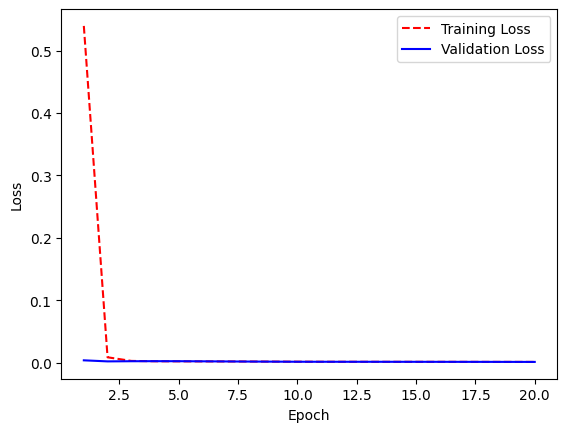

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

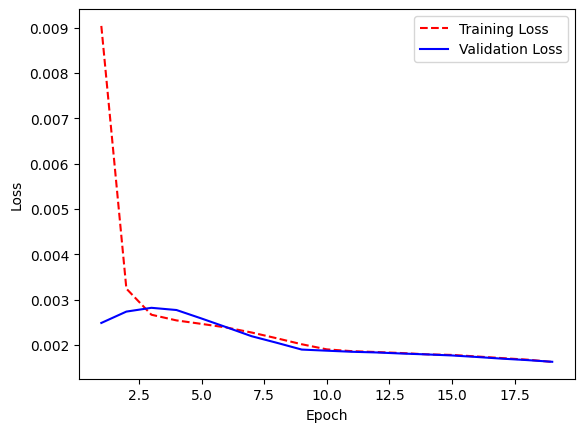

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_contrastive_model(margin=0.1, device=device)
    tpr, fpr = evaluate_siamese(model, test_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4984
False Positive Rate (FPR) for threshold 0.5: 0.5015
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.4976
False Positive Rate (FPR) for threshold 0.1: 0.5008
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0061
False Positive Rate (FPR) for threshold 0.01: 0.0007
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


In [ ]:
model = load_contrastive_model(margin=0.1, device=device)
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(model, train_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4983
False Positive Rate (FPR) for threshold 0.5: 0.5015
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.4977
False Positive Rate (FPR) for threshold 0.1: 0.5008
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0045
False Positive Rate (FPR) for threshold 0.01: 0.0005
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


#### get top

100%|██████████| 102/102 [00:11<00:00,  9.23it/s]


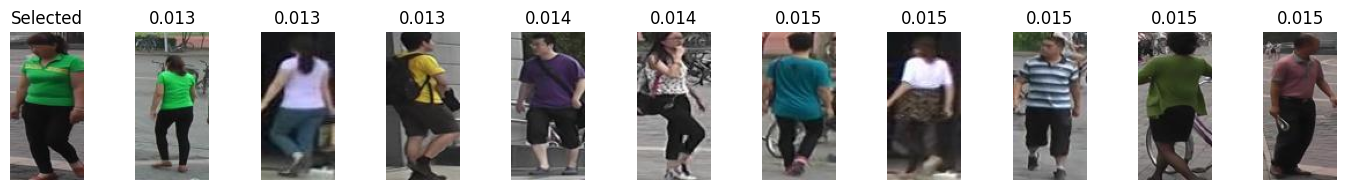

In [ ]:
model = load_contrastive_model(margin=0.1, device=device)
get_top10(model, data_df, all_data_ds, all_data_loader, device)

### Margin = 1

In [ ]:
margin = 1

base_model = load_efficientnet_model(embedding_size).to(device)
siamese_model_contrastive = SiameseNetwork(base_model).to(device)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(siamese_model_contrastive.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_contrastive , train_loss_epoch , val_loss_epoch = train_siamese_contrastive_loss(
    siamese_model_contrastive, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.64it/s, Loss=0.691]


Training Epoch [1/20], Average Loss: 0.6913


Epoch 1/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.84it/s, Validation Loss=0.265]


Validation Epoch [1/20], Average Loss: 0.2647
Model saved with best validation loss: 0.2647


Epoch 2/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.92it/s, Loss=0.203]


Training Epoch [2/20], Average Loss: 0.2025


Epoch 2/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.65it/s, Validation Loss=0.151]


Validation Epoch [2/20], Average Loss: 0.1506
Model saved with best validation loss: 0.1506


Epoch 3/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.73it/s, Loss=0.135]


Training Epoch [3/20], Average Loss: 0.1348


Epoch 3/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.90it/s, Validation Loss=0.11]


Validation Epoch [3/20], Average Loss: 0.1098
Model saved with best validation loss: 0.1098


Epoch 4/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.03it/s, Loss=0.0959]


Training Epoch [4/20], Average Loss: 0.0959


Epoch 4/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.63it/s, Validation Loss=0.0962]


Validation Epoch [4/20], Average Loss: 0.0962
Model saved with best validation loss: 0.0962


Epoch 5/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.91it/s, Loss=0.0717]


Training Epoch [5/20], Average Loss: 0.0717


Epoch 5/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.78it/s, Validation Loss=0.0951]


Validation Epoch [5/20], Average Loss: 0.0951
Model saved with best validation loss: 0.0951


Epoch 6/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.02it/s, Loss=0.0563]


Training Epoch [6/20], Average Loss: 0.0563


Epoch 6/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.82it/s, Validation Loss=0.097]


Validation Epoch [6/20], Average Loss: 0.0970


Epoch 7/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.92it/s, Loss=0.0482]


Training Epoch [7/20], Average Loss: 0.0482


Epoch 7/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.96it/s, Validation Loss=0.0965]


Validation Epoch [7/20], Average Loss: 0.0965


Epoch 8/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.06it/s, Loss=0.0415]


Training Epoch [8/20], Average Loss: 0.0415


Epoch 8/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.57it/s, Validation Loss=0.101]


Validation Epoch [8/20], Average Loss: 0.1012


Epoch 9/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.99it/s, Loss=0.0376]


Training Epoch [9/20], Average Loss: 0.0376


Epoch 9/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.01it/s, Validation Loss=0.0959]


Validation Epoch [9/20], Average Loss: 0.0959


Epoch 10/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.02it/s, Loss=0.0346]


Training Epoch [10/20], Average Loss: 0.0346


Epoch 10/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.89it/s, Validation Loss=0.1]


Validation Epoch [10/20], Average Loss: 0.1003


Epoch 11/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.03it/s, Loss=0.0303]


Training Epoch [11/20], Average Loss: 0.0303


Epoch 11/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.78it/s, Validation Loss=0.0842]


Validation Epoch [11/20], Average Loss: 0.0842
Model saved with best validation loss: 0.0842


Epoch 12/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.64it/s, Loss=0.0216]


Training Epoch [12/20], Average Loss: 0.0216


Epoch 12/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.07it/s, Validation Loss=0.0844]


Validation Epoch [12/20], Average Loss: 0.0844


Epoch 13/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.03it/s, Loss=0.0181]


Training Epoch [13/20], Average Loss: 0.0181


Epoch 13/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.62it/s, Validation Loss=0.0847]


Validation Epoch [13/20], Average Loss: 0.0847


Epoch 14/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.04it/s, Loss=0.0149]


Training Epoch [14/20], Average Loss: 0.0149


Epoch 14/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.90it/s, Validation Loss=0.0853]


Validation Epoch [14/20], Average Loss: 0.0853


Epoch 15/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.95it/s, Loss=0.0131]


Training Epoch [15/20], Average Loss: 0.0131


Epoch 15/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s, Validation Loss=0.0865]


Validation Epoch [15/20], Average Loss: 0.0865


Epoch 16/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.04it/s, Loss=0.012]


Training Epoch [16/20], Average Loss: 0.0120


Epoch 16/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.89it/s, Validation Loss=0.0867]


Validation Epoch [16/20], Average Loss: 0.0867


Epoch 17/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.90it/s, Loss=0.0104]


Training Epoch [17/20], Average Loss: 0.0104


Epoch 17/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.85it/s, Validation Loss=0.0878]


Validation Epoch [17/20], Average Loss: 0.0878


Epoch 18/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.05it/s, Loss=0.0101]


Training Epoch [18/20], Average Loss: 0.0101


Epoch 18/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.73it/s, Validation Loss=0.0862]


Validation Epoch [18/20], Average Loss: 0.0862


Epoch 19/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.01it/s, Loss=0.00938]


Training Epoch [19/20], Average Loss: 0.0094


Epoch 19/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 11.80it/s, Validation Loss=0.0895]


Validation Epoch [19/20], Average Loss: 0.0895


Epoch 20/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.02it/s, Loss=0.00882]


Training Epoch [20/20], Average Loss: 0.0088


Epoch 20/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.84it/s, Validation Loss=0.0894]

Validation Epoch [20/20], Average Loss: 0.0894


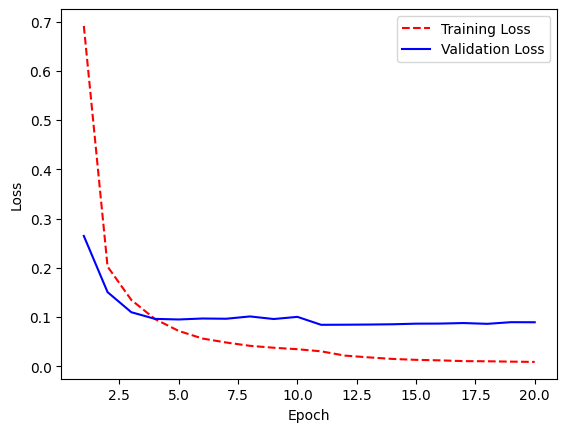

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

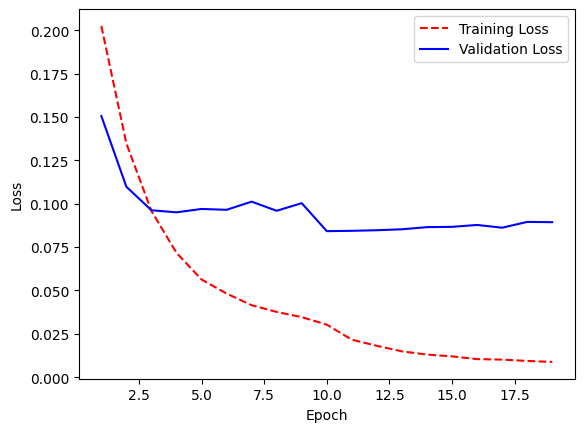

In [ ]:
plot_loss(train_loss_epoch[1:] , val_loss_epoch[1:])

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_contrastive_model(margin=1, device=device)
    tpr, fpr = evaluate_siamese(model, test_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")


True Positive Rate (TPR) for threshold 0.5: 0.4979
False Positive Rate (FPR) for threshold 0.5: 0.2963
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.3190
False Positive Rate (FPR) for threshold 0.1: 0.0159
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0045
False Positive Rate (FPR) for threshold 0.01: 0.0002
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


In [ ]:
model = load_contrastive_model(margin=1, device=device)
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(model, train_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4983
False Positive Rate (FPR) for threshold 0.5: 0.3084
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.3276
False Positive Rate (FPR) for threshold 0.1: 0.0180
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0073
False Positive Rate (FPR) for threshold 0.01: 0.0003
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0003
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


100%|██████████| 102/102 [00:11<00:00,  9.03it/s]


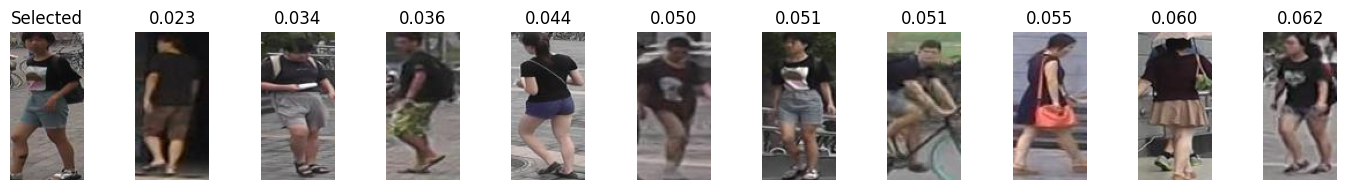

In [ ]:
model = load_contrastive_model(margin=1, device=device)
get_top10(model, data_df, all_data_ds, all_data_loader, device)

### Margin = 10

In [ ]:
margin = 10

base_model = load_efficientnet_model(embedding_size).to(device)
siamese_model_contrastive = SiameseNetwork(base_model).to(device)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(siamese_model_contrastive.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_contrastive , train_loss_epoch , val_loss_epoch = train_siamese_contrastive_loss(
    siamese_model_contrastive, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.01it/s, Loss=17.2]


Training Epoch [1/20], Average Loss: 17.2418


Epoch 1/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.11it/s, Validation Loss=9.31]


Validation Epoch [1/20], Average Loss: 9.3108
Model saved with best validation loss: 9.3108


Epoch 2/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.98it/s, Loss=10]


Training Epoch [2/20], Average Loss: 10.0275


Epoch 2/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.71it/s, Validation Loss=8.18]


Validation Epoch [2/20], Average Loss: 8.1759
Model saved with best validation loss: 8.1759


Epoch 3/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.95it/s, Loss=7.84]


Training Epoch [3/20], Average Loss: 7.8405


Epoch 3/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.70it/s, Validation Loss=7.85]


Validation Epoch [3/20], Average Loss: 7.8528
Model saved with best validation loss: 7.8528


Epoch 4/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.90it/s, Loss=6.66]


Training Epoch [4/20], Average Loss: 6.6648


Epoch 4/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.91it/s, Validation Loss=8.25]


Validation Epoch [4/20], Average Loss: 8.2464


Epoch 5/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.02it/s, Loss=5.76]


Training Epoch [5/20], Average Loss: 5.7590


Epoch 5/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.22it/s, Validation Loss=8.48]


Validation Epoch [5/20], Average Loss: 8.4829


Epoch 6/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.89it/s, Loss=5.06]


Training Epoch [6/20], Average Loss: 5.0610


Epoch 6/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.67it/s, Validation Loss=8.72]


Validation Epoch [6/20], Average Loss: 8.7173


Epoch 7/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  8.04it/s, Loss=4.64]


Training Epoch [7/20], Average Loss: 4.6388


Epoch 7/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.54it/s, Validation Loss=8.2]


Validation Epoch [7/20], Average Loss: 8.2021


Epoch 8/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.95it/s, Loss=4.08]


Training Epoch [8/20], Average Loss: 4.0846


Epoch 8/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.04it/s, Validation Loss=8.11]


Validation Epoch [8/20], Average Loss: 8.1100


Epoch 9/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.88it/s, Loss=3.76]


Training Epoch [9/20], Average Loss: 3.7630


Epoch 9/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.18it/s, Validation Loss=8.42]


Validation Epoch [9/20], Average Loss: 8.4249


Epoch 10/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.57it/s, Loss=3.52]


Training Epoch [10/20], Average Loss: 3.5248


Epoch 10/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.11it/s, Validation Loss=8.24]


Validation Epoch [10/20], Average Loss: 8.2423


Epoch 11/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.87it/s, Loss=3.18]


Training Epoch [11/20], Average Loss: 3.1837


Epoch 11/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.48it/s, Validation Loss=6.89]


Validation Epoch [11/20], Average Loss: 6.8876
Model saved with best validation loss: 6.8876


Epoch 12/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.96it/s, Loss=2.27]


Training Epoch [12/20], Average Loss: 2.2684


Epoch 12/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.10it/s, Validation Loss=6.9]


Validation Epoch [12/20], Average Loss: 6.9032


Epoch 13/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.87it/s, Loss=1.86]


Training Epoch [13/20], Average Loss: 1.8627


Epoch 13/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.63it/s, Validation Loss=6.96]


Validation Epoch [13/20], Average Loss: 6.9591


Epoch 14/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.94it/s, Loss=1.58]


Training Epoch [14/20], Average Loss: 1.5753


Epoch 14/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.54it/s, Validation Loss=7.05]


Validation Epoch [14/20], Average Loss: 7.0486


Epoch 15/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.62it/s, Loss=1.33]


Training Epoch [15/20], Average Loss: 1.3251


Epoch 15/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.75it/s, Validation Loss=7.14]


Validation Epoch [15/20], Average Loss: 7.1390


Epoch 16/20 - Training: 100%|██████████| 372/372 [00:47<00:00,  7.86it/s, Loss=1.18]


Training Epoch [16/20], Average Loss: 1.1807


Epoch 16/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.65it/s, Validation Loss=7.29]


Validation Epoch [16/20], Average Loss: 7.2892


Epoch 17/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.73it/s, Loss=1.04]


Training Epoch [17/20], Average Loss: 1.0399


Epoch 17/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.46it/s, Validation Loss=7.25]


Validation Epoch [17/20], Average Loss: 7.2460


Epoch 18/20 - Training: 100%|██████████| 372/372 [00:46<00:00,  7.92it/s, Loss=0.928]


Training Epoch [18/20], Average Loss: 0.9278


Epoch 18/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.94it/s, Validation Loss=7.41]


Validation Epoch [18/20], Average Loss: 7.4068


Epoch 19/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.75it/s, Loss=0.825]


Training Epoch [19/20], Average Loss: 0.8254


Epoch 19/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.16it/s, Validation Loss=7.4]


Validation Epoch [19/20], Average Loss: 7.4034


Epoch 20/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.44it/s, Loss=0.749]


Training Epoch [20/20], Average Loss: 0.7494


Epoch 20/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.24it/s, Validation Loss=7.45]

Validation Epoch [20/20], Average Loss: 7.4450


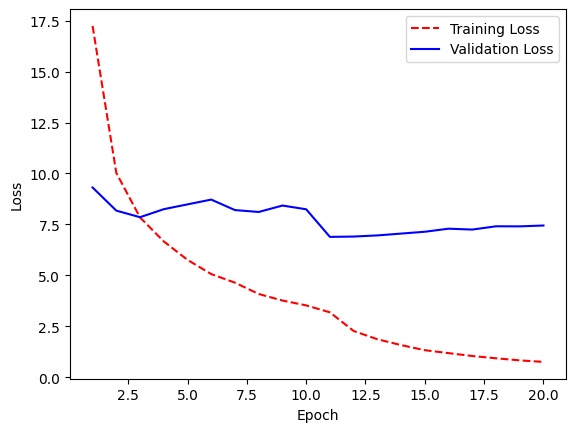

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

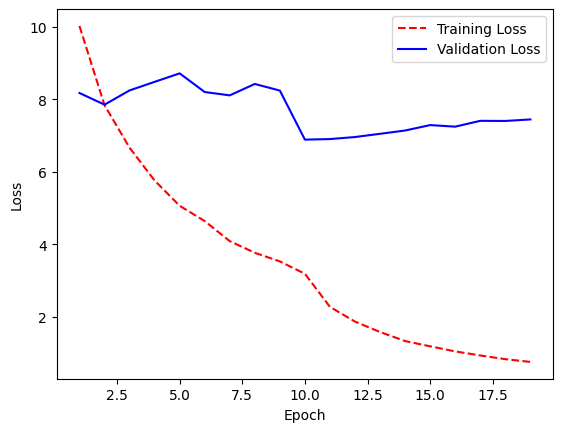

In [ ]:
plot_loss(train_loss_epoch[1:] , val_loss_epoch[1:])

In [ ]:
model = load_contrastive_model(margin=10, device=device)
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(model, train_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 143MB/s]


True Positive Rate (TPR) for threshold 0.5: 0.4971
False Positive Rate (FPR) for threshold 0.5: 0.2304
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.3325
False Positive Rate (FPR) for threshold 0.1: 0.0130
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0080
False Positive Rate (FPR) for threshold 0.01: 0.0001
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0003
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


In [ ]:
model = load_contrastive_model(margin=10, device=device)
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(model, test_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")


True Positive Rate (TPR) for threshold 0.5: 0.4979
False Positive Rate (FPR) for threshold 0.5: 0.2381
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.3369
False Positive Rate (FPR) for threshold 0.1: 0.0134
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0060
False Positive Rate (FPR) for threshold 0.01: 0.0000
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


100%|██████████| 102/102 [00:11<00:00,  8.75it/s]


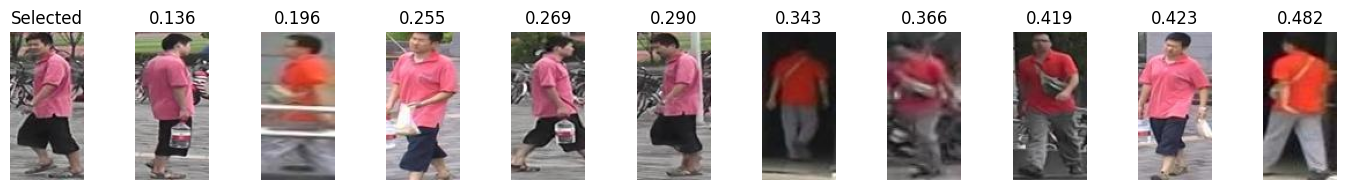

In [ ]:
model = load_contrastive_model(margin=10, device=device)
get_top10(model, data_df, all_data_ds, all_data_loader, device)

## Triplet loss

### utils

In [ ]:
def load_triplet_model(margin, device):
    base_model = load_efficientnet_model(embedding_size).to(device)
    siamese_model_triplet = SiameseNetworkTriplet(base_model).to(device)
    siamese_model_triplet.load_state_dict(torch.load(os.path.join(model_config_dir, f'best_model_triplet_m{margin}.pth')))
    return siamese_model_triplet

In [ ]:
class SiameseNetworkTriplet(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetworkTriplet, self).__init__()
        self.base_model = base_model

    def forward_one(self, x):
        x = self.base_model(x)
        return x

    def forward(self, anchor, positive , negative):
        out_anchor = self.forward_one(anchor)
        out_pos = self.forward_one(positive)
        out_neg = self.forward_one(negative)
        return out_anchor, out_pos, out_neg

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)

        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(loss)


In [ ]:
def train_siamese_triplet_loss(model, train_loader, val_loader, criterion, optimizer,scheduler,  checkpoint_path,margin, num_epochs=10):
    best_val_loss = float('inf')
    train_loss_epoch = []
    val_loss_epoch = []


    for epoch in range(num_epochs):
        total_loss_train = 0.0
        total_loss_val = 0.0

        # Training
        model.train()
        train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Training')

        for batch_idx, (anchor ,positive , negative) in train_pbar:

            anchor ,positive , negative= anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()

            out_anchor, out_pos, out_neg = model(anchor ,positive , negative)
            loss = criterion(out_anchor, out_pos, out_neg)

            loss.backward()
            optimizer.step()
            total_loss_train += loss.item()
            train_pbar.set_postfix({'Loss': total_loss_train / (batch_idx + 1)})


        average_loss_train = total_loss_train / len(train_loader.dataset)
        train_loss_epoch.append(average_loss_train)
        print(f'Training Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_train:.4f}')

        # Validation
        model.eval()
        with torch.no_grad():
            val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Validation')

            for batch_idx, (anchor ,positive , negative) in val_pbar:
                anchor ,positive , negative= anchor.to(device), positive.to(device), negative.to(device)
                out_anchor, out_pos, out_neg = model(anchor ,positive , negative)
                val_loss = criterion(out_anchor, out_pos, out_neg)
                total_loss_val += val_loss.item()
                val_pbar.set_postfix({'Validation Loss': total_loss_val / (batch_idx+1)})

        average_loss_val = total_loss_val / len(val_loader.dataset)
        val_loss_epoch.append(average_loss_val)
        print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_val:.4f}')

        scheduler.step()

        # Save the model if the validation loss is the best so far
        if average_loss_val < best_val_loss:
            best_val_loss = average_loss_val
            torch.save(model.state_dict(), os.path.join(checkpoint_path , f'best_model_triplet_m{margin}.pth'))
            print(f'Model saved with best validation loss: {best_val_loss:.4f}')



    return model , train_loss_epoch , val_loss_epoch

In [ ]:
def evaluate_siamese_triplet(model, test_loader, threshold=0.9):
    model.eval()
    true_positive = 0
    false_positive = 0
    total_pairs = 0
    pos_dists =[]
    neg_dists =[]

    with torch.no_grad():
        for batch_idx, (anchor ,positive , negative) in enumerate(test_loader):
            anchor ,positive , negative = anchor.to(device),positive.to(device), negative.to(device)

            out_anchor ,out_positive , out_negative = model(anchor ,positive , negative)


            euclidean_distance_pos = F.pairwise_distance(out_anchor, out_positive)
            euclidean_distance_neg = F.pairwise_distance(out_anchor, out_negative)

            pos_dists += euclidean_distance_pos
            neg_dists += euclidean_distance_neg

        pos_dists = torch.stack(pos_dists)
        neg_dists = torch.stack(neg_dists)

        p_min_dist, _ = torch.min(pos_dists,0)
        n_min_dist, _ = torch.min(neg_dists,0)
        p_max_dist, _ = torch.max(pos_dists,0)
        n_max_dist, _ = torch.max(neg_dists,0)

        pos_dists = (pos_dists - p_min_dist) / (p_max_dist - p_min_dist)
        neg_dists = (neg_dists - n_min_dist) / (n_max_dist - n_min_dist)

        tp = pos_dists < threshold
        fp = neg_dists < threshold



    return sum(tp) / pos_dists.shape[0] , sum(fp)/ neg_dists.shape[0]




In [ ]:
def get_top10_triplet(model, all_data_df, all_data_ds, all_data_loader, device):
    anchor_idx = np.random.randint(len(all_data_df))
    anchor_img = all_data_ds[anchor_idx]
    anchor_img = anchor_img.unsqueeze(dim=0).to(device)

    distances = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (img) in enumerate(tqdm(all_data_loader)):
            img = img.to(device)
            output0 = model.base_model(anchor_img)
            output1 = model.base_model(img)
            euclidean_distance = F.pairwise_distance(output0, output1)
            distances.append(euclidean_distance)

    distances = torch.concat(distances)

    top10 = torch.topk(distances, k=11, largest=False)  # first one is the Anchor image
    fig, axs = plt.subplots(1, 11, figsize=(14, 2))

    axs[0].imshow(Image.open(data_df.iloc[anchor_idx, 0]), cmap='viridis')
    axs[0].axis('off')
    axs[0].set_title("Selected")

    for i in range(1, len(top10.indices)):
        neighbor_idx = top10.indices[i].detach().cpu().item()
        neighbor_dist = top10.values[i].detach().cpu().item()
        axs[i].imshow(Image.open(all_data_df.iloc[neighbor_idx, 0]), cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f"{neighbor_dist:.3f}")

    plt.tight_layout()
    plt.show()

### preparing data

In [ ]:
from PIL import Image


class SiameseDatasetTriplet(Dataset):
    def __init__(self,triplets, transform=None):
        self.transform = transform
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        triple = self.triplets[idx]
        anchor = triple[0]
        positive = triple[1][0]
        negative = triple[2][0]

        anchor_img = Image.open(anchor).convert("RGB") # Reading image
        pos_img = Image.open(positive).convert("RGB") # Reading image
        neg_img = Image.open(negative).convert("RGB") # Reading image

        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anchor_img , pos_img , neg_img

In [ ]:
from random import shuffle

def generate_triplets(df ,num_triplet , anchor_id):
    triplets = []
    positive_paths = df[df['id'] == anchor_id]['path']
    negative_paths = df[df['id'] != anchor_id]['path']

    positive_pairs = list(itertools.combinations(positive_paths, 2))

    if num_triplet > len(positive_pairs):
        for pair in positive_pairs:
            anchor = pair[0]
            positive = pair[1]
            negative = negative_paths.sample(1).values[0]
            triplets.append([anchor , [positive, 0] , [negative,1]])

    else:
        shuffle(positive_pairs)
        for i in range(num_triplet):
            anchor = positive_pairs[i][0]
            positive =  positive_pairs[i][1]
            negative = negative_paths.sample(1).values[0]
            triplets.append([anchor , [positive, 0] , [negative,1]])

    return triplets

In [ ]:
total_triplets= []
for id in data_df['id'].unique():
    total_triplets.append(generate_triplets(data_df , 20 , anchor_id = id))


In [ ]:
total_triplets = [
    x
    for xs in total_triplets
    for x in xs
]

In [ ]:
train_df_triplet, test_df_triplet = train_test_split(total_triplets, test_size=0.2, random_state=42, shuffle=True)
test_df_triplet, val_df_triplet = train_test_split(test_df_triplet, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
len(train_df_triplet) , len(val_df_triplet) , len(test_df_triplet)

(11328, 1417, 1416)

In [ ]:
train_ds_triplet = SiameseDatasetTriplet(triplets=train_df_triplet, transform=data_transforms)
val_ds_triplet = SiameseDatasetTriplet(triplets=val_df_triplet, transform=data_transforms)
test_ds_triplet = SiameseDatasetTriplet(triplets=test_df_triplet, transform=data_transforms)

train_loader_triplet =DataLoader(train_ds_triplet, batch_size=batch_sizes['train'])
val_loader_triplet =DataLoader(val_ds_triplet, batch_size=batch_sizes['val'])
test_loader_triplet =DataLoader(train_ds_triplet, batch_size=batch_sizes['train'])


### Margin = 0.1

In [ ]:
margin = 0.1

base_model = load_efficientnet_model(embedding_size).to(device)
siamese_model_triplet = SiameseNetworkTriplet(base_model).to(device)
criterion = TripletLoss(margin)

optimizer = optim.Adam(siamese_model_triplet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_triplet , train_loss_epoch , val_loss_epoch = train_siamese_triplet_loss(
    siamese_model_triplet, train_loader_triplet, val_loader_triplet, criterion, optimizer, scheduler, model_config_dir, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 354/354 [01:25<00:00,  4.13it/s, Loss=0.122]


Training Epoch [1/20], Average Loss: 0.0038


Epoch 1/20 - Validation: 100%|██████████| 45/45 [00:07<00:00,  6.00it/s, Validation Loss=0.03]


Validation Epoch [1/20], Average Loss: 0.0010
Model saved with best validation loss: 0.0010


Epoch 2/20 - Training: 100%|██████████| 354/354 [01:16<00:00,  4.63it/s, Loss=0.0244]


Training Epoch [2/20], Average Loss: 0.0008


Epoch 2/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.28it/s, Validation Loss=0.019]


Validation Epoch [2/20], Average Loss: 0.0006
Model saved with best validation loss: 0.0006


Epoch 3/20 - Training: 100%|██████████| 354/354 [01:09<00:00,  5.07it/s, Loss=0.0137]


Training Epoch [3/20], Average Loss: 0.0004


Epoch 3/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.49it/s, Validation Loss=0.0191]


Validation Epoch [3/20], Average Loss: 0.0006


Epoch 4/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.011]


Training Epoch [4/20], Average Loss: 0.0003


Epoch 4/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.16it/s, Validation Loss=0.0173]


Validation Epoch [4/20], Average Loss: 0.0006
Model saved with best validation loss: 0.0006


Epoch 5/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.34it/s, Loss=0.00748]


Training Epoch [5/20], Average Loss: 0.0002


Epoch 5/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.70it/s, Validation Loss=0.0138]


Validation Epoch [5/20], Average Loss: 0.0004
Model saved with best validation loss: 0.0004


Epoch 6/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.38it/s, Loss=0.00841]


Training Epoch [6/20], Average Loss: 0.0003


Epoch 6/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.41it/s, Validation Loss=0.015]


Validation Epoch [6/20], Average Loss: 0.0005


Epoch 7/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.44it/s, Loss=0.00886]


Training Epoch [7/20], Average Loss: 0.0003


Epoch 7/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.96it/s, Validation Loss=0.0167]


Validation Epoch [7/20], Average Loss: 0.0005


Epoch 8/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.39it/s, Loss=0.0101]


Training Epoch [8/20], Average Loss: 0.0003


Epoch 8/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.06it/s, Validation Loss=0.0125]


Validation Epoch [8/20], Average Loss: 0.0004
Model saved with best validation loss: 0.0004


Epoch 9/20 - Training: 100%|██████████| 354/354 [01:11<00:00,  4.97it/s, Loss=0.011]


Training Epoch [9/20], Average Loss: 0.0003


Epoch 9/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.78it/s, Validation Loss=0.021]


Validation Epoch [9/20], Average Loss: 0.0007


Epoch 10/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.014]


Training Epoch [10/20], Average Loss: 0.0004


Epoch 10/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.07it/s, Validation Loss=0.0138]


Validation Epoch [10/20], Average Loss: 0.0004


Epoch 11/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.15it/s, Loss=0.00617]


Training Epoch [11/20], Average Loss: 0.0002


Epoch 11/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.10it/s, Validation Loss=0.00686]


Validation Epoch [11/20], Average Loss: 0.0002
Model saved with best validation loss: 0.0002


Epoch 12/20 - Training: 100%|██████████| 354/354 [01:09<00:00,  5.12it/s, Loss=0.00244]


Training Epoch [12/20], Average Loss: 0.0001


Epoch 12/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.09it/s, Validation Loss=0.00601]


Validation Epoch [12/20], Average Loss: 0.0002
Model saved with best validation loss: 0.0002


Epoch 13/20 - Training: 100%|██████████| 354/354 [01:09<00:00,  5.10it/s, Loss=0.00153]


Training Epoch [13/20], Average Loss: 0.0000


Epoch 13/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.24it/s, Validation Loss=0.00673]


Validation Epoch [13/20], Average Loss: 0.0002


Epoch 14/20 - Training: 100%|██████████| 354/354 [01:09<00:00,  5.13it/s, Loss=0.000919]


Training Epoch [14/20], Average Loss: 0.0000


Epoch 14/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.97it/s, Validation Loss=0.00631]


Validation Epoch [14/20], Average Loss: 0.0002


Epoch 15/20 - Training: 100%|██████████| 354/354 [01:10<00:00,  4.99it/s, Loss=0.000619]


Training Epoch [15/20], Average Loss: 0.0000


Epoch 15/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.97it/s, Validation Loss=0.00657]


Validation Epoch [15/20], Average Loss: 0.0002


Epoch 16/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.35it/s, Loss=0.00032]


Training Epoch [16/20], Average Loss: 0.0000


Epoch 16/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.21it/s, Validation Loss=0.00655]


Validation Epoch [16/20], Average Loss: 0.0002


Epoch 17/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.35it/s, Loss=0.000387]


Training Epoch [17/20], Average Loss: 0.0000


Epoch 17/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.22it/s, Validation Loss=0.00726]


Validation Epoch [17/20], Average Loss: 0.0002


Epoch 18/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.41it/s, Loss=0.000223]


Training Epoch [18/20], Average Loss: 0.0000


Epoch 18/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.98it/s, Validation Loss=0.00808]


Validation Epoch [18/20], Average Loss: 0.0003


Epoch 19/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.39it/s, Loss=0.000198]


Training Epoch [19/20], Average Loss: 0.0000


Epoch 19/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.44it/s, Validation Loss=0.00747]


Validation Epoch [19/20], Average Loss: 0.0002


Epoch 20/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.39it/s, Loss=0.000262]


Training Epoch [20/20], Average Loss: 0.0000


Epoch 20/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.45it/s, Validation Loss=0.00857]

Validation Epoch [20/20], Average Loss: 0.0003


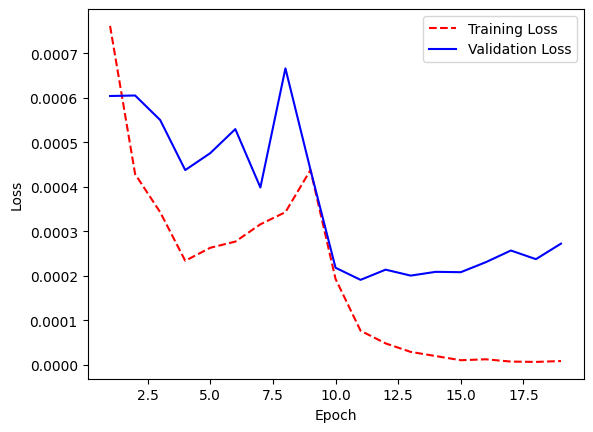

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

In [ ]:
threshold_values = [0.001 , 0.01 , 0.1 , 0.5]

tpr_values_ = []
fpr_values_ = []
for threshold in threshold_values:
    tpr, fpr = evaluate_siamese_triplet(model, test_loader_triplet , threshold)
    tpr_values_.append(tpr.detach().cpu().numpy())
    fpr_values_.append(fpr.detach().cpu().numpy())

In [ ]:
for i in range(len(fpr_values_)):
    print(f'True Positive Rate (TPR) for threshold {threshold_values[i]}: {tpr_values_[i]:.4f}')
    print(f'False Positive Rate (FPR) for threshold {threshold_values[i]}: {fpr_values_[i]:.4f}')
    print("*********************************")


True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0004
False Positive Rate (FPR) for threshold 0.01: 0.0003
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0562
False Positive Rate (FPR) for threshold 0.1: 0.0075
*********************************
True Positive Rate (TPR) for threshold 0.5: 0.9418
False Positive Rate (FPR) for threshold 0.5: 0.4934
*********************************


In [ ]:
tpr_values = []
fpr_values = []
for threshold in threshold_values:
    tpr, fpr = evaluate_siamese_triplet(model, train_loader_triplet , threshold)
    tpr_values.append(tpr.detach().cpu())
    fpr_values.append(fpr.detach().cpu())



In [ ]:
for i in range(len(tpr_values)):
    print(f'True Positive Rate (TPR) for threshold {threshold_values[i]}: {tpr_values[i]:.4f}')
    print(f'False Positive Rate (FPR) for threshold {threshold_values[i]}: {fpr_values[i]:.4f}')
    print("*********************************")


True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0004
False Positive Rate (FPR) for threshold 0.01: 0.0003
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0562
False Positive Rate (FPR) for threshold 0.1: 0.0075
*********************************
True Positive Rate (TPR) for threshold 0.5: 0.9418
False Positive Rate (FPR) for threshold 0.5: 0.4934
*********************************


100%|██████████| 102/102 [00:11<00:00,  8.53it/s]


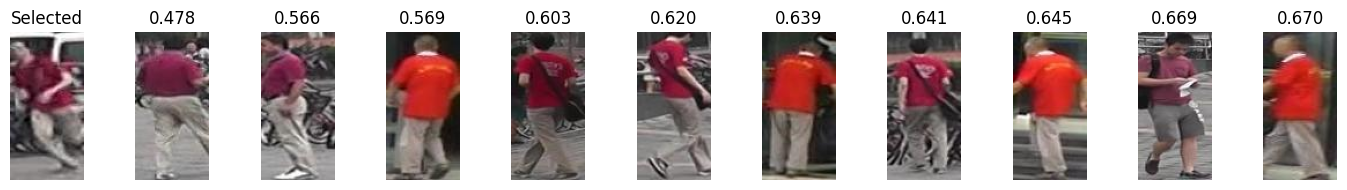

In [ ]:
model = load_triplet_model(margin=0.1, device=device)
get_top10_triplet(model, data_df, all_data_ds, all_data_loader, device)

### Margin = 1

In [ ]:
margin = 1

base_model = load_efficientnet_model(embedding_size).to(device)
siamese_model_triplet = SiameseNetworkTriplet(base_model).to(device)
criterion = TripletLoss(margin)

optimizer = optim.Adam(siamese_model_triplet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_triplet , train_loss_epoch , val_loss_epoch = train_siamese_triplet_loss(
    siamese_model_triplet, train_loader_triplet, val_loader_triplet, criterion, optimizer, scheduler, model_config_dir, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 354/354 [01:09<00:00,  5.11it/s, Loss=0.344]


Training Epoch [1/20], Average Loss: 0.0107


Epoch 1/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.39it/s, Validation Loss=0.209]


Validation Epoch [1/20], Average Loss: 0.0066
Model saved with best validation loss: 0.0066


Epoch 2/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=0.134]


Training Epoch [2/20], Average Loss: 0.0042


Epoch 2/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.80it/s, Validation Loss=0.0846]


Validation Epoch [2/20], Average Loss: 0.0027
Model saved with best validation loss: 0.0027


Epoch 3/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.33it/s, Loss=0.0889]


Training Epoch [3/20], Average Loss: 0.0028


Epoch 3/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.29it/s, Validation Loss=0.0914]


Validation Epoch [3/20], Average Loss: 0.0029


Epoch 4/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.35it/s, Loss=0.061]


Training Epoch [4/20], Average Loss: 0.0019


Epoch 4/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.16it/s, Validation Loss=0.0916]


Validation Epoch [4/20], Average Loss: 0.0029


Epoch 5/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.34it/s, Loss=0.0516]


Training Epoch [5/20], Average Loss: 0.0016


Epoch 5/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.50it/s, Validation Loss=0.0972]


Validation Epoch [5/20], Average Loss: 0.0031


Epoch 6/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.34it/s, Loss=0.0598]


Training Epoch [6/20], Average Loss: 0.0019


Epoch 6/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.90it/s, Validation Loss=0.0791]


Validation Epoch [6/20], Average Loss: 0.0025
Model saved with best validation loss: 0.0025


Epoch 7/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.18it/s, Loss=0.0454]


Training Epoch [7/20], Average Loss: 0.0014


Epoch 7/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.24it/s, Validation Loss=0.0857]


Validation Epoch [7/20], Average Loss: 0.0027


Epoch 8/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.40it/s, Loss=0.0475]


Training Epoch [8/20], Average Loss: 0.0015


Epoch 8/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.54it/s, Validation Loss=0.0733]


Validation Epoch [8/20], Average Loss: 0.0023
Model saved with best validation loss: 0.0023


Epoch 9/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=0.0574]


Training Epoch [9/20], Average Loss: 0.0018


Epoch 9/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.69it/s, Validation Loss=0.0846]


Validation Epoch [9/20], Average Loss: 0.0027


Epoch 10/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.30it/s, Loss=0.039]


Training Epoch [10/20], Average Loss: 0.0012


Epoch 10/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.31it/s, Validation Loss=0.109]


Validation Epoch [10/20], Average Loss: 0.0035


Epoch 11/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.37it/s, Loss=0.0231]


Training Epoch [11/20], Average Loss: 0.0007


Epoch 11/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.10it/s, Validation Loss=0.0632]


Validation Epoch [11/20], Average Loss: 0.0020
Model saved with best validation loss: 0.0020


Epoch 12/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.38it/s, Loss=0.00748]


Training Epoch [12/20], Average Loss: 0.0002


Epoch 12/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.33it/s, Validation Loss=0.058]


Validation Epoch [12/20], Average Loss: 0.0018
Model saved with best validation loss: 0.0018


Epoch 13/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.40it/s, Loss=0.00293]


Training Epoch [13/20], Average Loss: 0.0001


Epoch 13/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.53it/s, Validation Loss=0.0567]


Validation Epoch [13/20], Average Loss: 0.0018
Model saved with best validation loss: 0.0018


Epoch 14/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.42it/s, Loss=0.00207]


Training Epoch [14/20], Average Loss: 0.0001


Epoch 14/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.09it/s, Validation Loss=0.0569]


Validation Epoch [14/20], Average Loss: 0.0018


Epoch 15/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.38it/s, Loss=0.00175]


Training Epoch [15/20], Average Loss: 0.0001


Epoch 15/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.76it/s, Validation Loss=0.0614]


Validation Epoch [15/20], Average Loss: 0.0020


Epoch 16/20 - Training: 100%|██████████| 354/354 [01:11<00:00,  4.94it/s, Loss=0.000927]


Training Epoch [16/20], Average Loss: 0.0000


Epoch 16/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.53it/s, Validation Loss=0.0621]


Validation Epoch [16/20], Average Loss: 0.0020


Epoch 17/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.39it/s, Loss=0.000665]


Training Epoch [17/20], Average Loss: 0.0000


Epoch 17/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.22it/s, Validation Loss=0.0594]


Validation Epoch [17/20], Average Loss: 0.0019


Epoch 18/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.000723]


Training Epoch [18/20], Average Loss: 0.0000


Epoch 18/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.33it/s, Validation Loss=0.0586]


Validation Epoch [18/20], Average Loss: 0.0019


Epoch 19/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.33it/s, Loss=0.00104]


Training Epoch [19/20], Average Loss: 0.0000


Epoch 19/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.12it/s, Validation Loss=0.0569]


Validation Epoch [19/20], Average Loss: 0.0018


Epoch 20/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.40it/s, Loss=0.000783]


Training Epoch [20/20], Average Loss: 0.0000


Epoch 20/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.85it/s, Validation Loss=0.0533]


Validation Epoch [20/20], Average Loss: 0.0017
Model saved with best validation loss: 0.0017


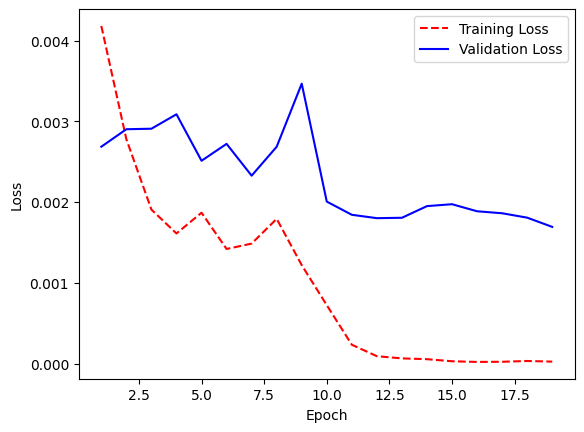

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_triplet_model(margin=1, device=device)
    tpr, fpr = evaluate_siamese_triplet(model, test_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9507
False Positive Rate (FPR) for threshold 0.5: 0.4302
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0656
False Positive Rate (FPR) for threshold 0.1: 0.0020
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0004
False Positive Rate (FPR) for threshold 0.01: 0.0001
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_triplet_model(margin=1, device=device)
    tpr, fpr = evaluate_siamese_triplet(model, train_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9507
False Positive Rate (FPR) for threshold 0.5: 0.4302
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0656
False Positive Rate (FPR) for threshold 0.1: 0.0020
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0004
False Positive Rate (FPR) for threshold 0.01: 0.0001
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


100%|██████████| 102/102 [00:12<00:00,  8.48it/s]


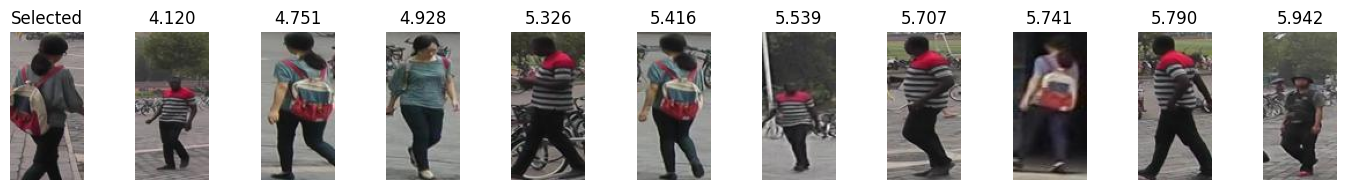

In [ ]:
model = load_triplet_model(margin=1, device=device)
get_top10_triplet(model, data_df, all_data_ds, all_data_loader, device)

### Margin = 10

In [ ]:
margin = 10

base_model = load_efficientnet_model(embedding_size).to(device)
siamese_model_triplet = SiameseNetworkTriplet(base_model).to(device)
criterion = TripletLoss(margin)

optimizer = optim.Adam(siamese_model_triplet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_triplet , train_loss_epoch , val_loss_epoch = train_siamese_triplet_loss(
    siamese_model_triplet, train_loader_triplet, val_loader_triplet, criterion, optimizer, scheduler, model_config_dir, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.40it/s, Loss=3.06]


Training Epoch [1/20], Average Loss: 0.0957


Epoch 1/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.10it/s, Validation Loss=1.45]


Validation Epoch [1/20], Average Loss: 0.0459
Model saved with best validation loss: 0.0459


Epoch 2/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.20it/s, Loss=1.14]


Training Epoch [2/20], Average Loss: 0.0357


Epoch 2/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.27it/s, Validation Loss=1.09]


Validation Epoch [2/20], Average Loss: 0.0347
Model saved with best validation loss: 0.0347


Epoch 3/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.34it/s, Loss=0.74]


Training Epoch [3/20], Average Loss: 0.0231


Epoch 3/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.30it/s, Validation Loss=0.836]


Validation Epoch [3/20], Average Loss: 0.0266
Model saved with best validation loss: 0.0266


Epoch 4/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.35it/s, Loss=0.574]


Training Epoch [4/20], Average Loss: 0.0179


Epoch 4/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.28it/s, Validation Loss=0.854]


Validation Epoch [4/20], Average Loss: 0.0271


Epoch 5/20 - Training: 100%|██████████| 354/354 [01:09<00:00,  5.07it/s, Loss=0.53]


Training Epoch [5/20], Average Loss: 0.0165


Epoch 5/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.96it/s, Validation Loss=1]


Validation Epoch [5/20], Average Loss: 0.0318


Epoch 6/20 - Training: 100%|██████████| 354/354 [01:17<00:00,  4.58it/s, Loss=0.426]


Training Epoch [6/20], Average Loss: 0.0133


Epoch 6/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.30it/s, Validation Loss=0.693]


Validation Epoch [6/20], Average Loss: 0.0220
Model saved with best validation loss: 0.0220


Epoch 7/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=0.415]


Training Epoch [7/20], Average Loss: 0.0130


Epoch 7/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.31it/s, Validation Loss=0.729]


Validation Epoch [7/20], Average Loss: 0.0232


Epoch 8/20 - Training: 100%|██████████| 354/354 [01:17<00:00,  4.58it/s, Loss=0.361]


Training Epoch [8/20], Average Loss: 0.0113


Epoch 8/20 - Validation: 100%|██████████| 45/45 [00:08<00:00,  5.37it/s, Validation Loss=0.707]


Validation Epoch [8/20], Average Loss: 0.0225


Epoch 9/20 - Training: 100%|██████████| 354/354 [01:14<00:00,  4.78it/s, Loss=0.262]


Training Epoch [9/20], Average Loss: 0.0082


Epoch 9/20 - Validation: 100%|██████████| 45/45 [00:06<00:00,  7.33it/s, Validation Loss=0.822]


Validation Epoch [9/20], Average Loss: 0.0261


Epoch 10/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.34it/s, Loss=0.377]


Training Epoch [10/20], Average Loss: 0.0118


Epoch 10/20 - Validation: 100%|██████████| 45/45 [00:06<00:00,  7.09it/s, Validation Loss=0.842]


Validation Epoch [10/20], Average Loss: 0.0267


Epoch 11/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=0.164]


Training Epoch [11/20], Average Loss: 0.0051


Epoch 11/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.25it/s, Validation Loss=0.711]


Validation Epoch [11/20], Average Loss: 0.0226


Epoch 12/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.29it/s, Loss=0.0558]


Training Epoch [12/20], Average Loss: 0.0017


Epoch 12/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.17it/s, Validation Loss=0.657]


Validation Epoch [12/20], Average Loss: 0.0209
Model saved with best validation loss: 0.0209


Epoch 13/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.35it/s, Loss=0.0308]


Training Epoch [13/20], Average Loss: 0.0010


Epoch 13/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.30it/s, Validation Loss=0.635]


Validation Epoch [13/20], Average Loss: 0.0202
Model saved with best validation loss: 0.0202


Epoch 14/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.33it/s, Loss=0.0165]


Training Epoch [14/20], Average Loss: 0.0005


Epoch 14/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.93it/s, Validation Loss=0.616]


Validation Epoch [14/20], Average Loss: 0.0196
Model saved with best validation loss: 0.0196


Epoch 15/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.37it/s, Loss=0.013]


Training Epoch [15/20], Average Loss: 0.0004


Epoch 15/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.05it/s, Validation Loss=0.623]


Validation Epoch [15/20], Average Loss: 0.0198


Epoch 16/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.42it/s, Loss=0.00381]


Training Epoch [16/20], Average Loss: 0.0001


Epoch 16/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.96it/s, Validation Loss=0.603]


Validation Epoch [16/20], Average Loss: 0.0191
Model saved with best validation loss: 0.0191


Epoch 17/20 - Training: 100%|██████████| 354/354 [01:05<00:00,  5.38it/s, Loss=0.00612]


Training Epoch [17/20], Average Loss: 0.0002


Epoch 17/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.20it/s, Validation Loss=0.602]


Validation Epoch [17/20], Average Loss: 0.0191
Model saved with best validation loss: 0.0191


Epoch 18/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.00528]


Training Epoch [18/20], Average Loss: 0.0002


Epoch 18/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  7.84it/s, Validation Loss=0.607]


Validation Epoch [18/20], Average Loss: 0.0193


Epoch 19/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.00469]


Training Epoch [19/20], Average Loss: 0.0001


Epoch 19/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.25it/s, Validation Loss=0.602]


Validation Epoch [19/20], Average Loss: 0.0191
Model saved with best validation loss: 0.0191


Epoch 20/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.30it/s, Loss=0.00353]


Training Epoch [20/20], Average Loss: 0.0001


Epoch 20/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.19it/s, Validation Loss=0.626]

Validation Epoch [20/20], Average Loss: 0.0199


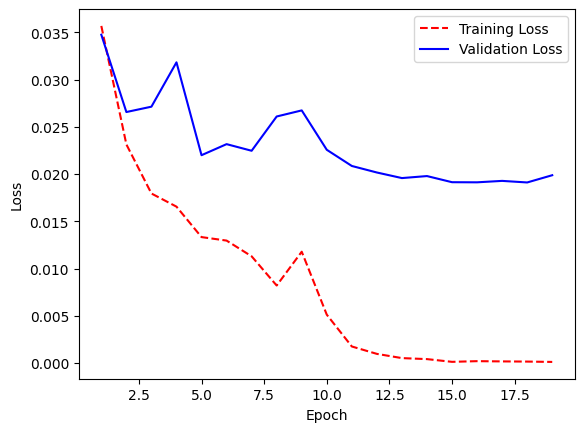

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_triplet_model(margin=10, device=device)
    tpr, fpr = evaluate_siamese_triplet(model, test_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9896
False Positive Rate (FPR) for threshold 0.5: 0.5930
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1546
False Positive Rate (FPR) for threshold 0.1: 0.0065
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0002
False Positive Rate (FPR) for threshold 0.01: 0.0002
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_triplet_model(margin=10, device=device)
    tpr, fpr = evaluate_siamese_triplet(model, train_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9896
False Positive Rate (FPR) for threshold 0.5: 0.5930
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1546
False Positive Rate (FPR) for threshold 0.1: 0.0065
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0002
False Positive Rate (FPR) for threshold 0.01: 0.0002
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


100%|██████████| 102/102 [00:15<00:00,  6.77it/s]


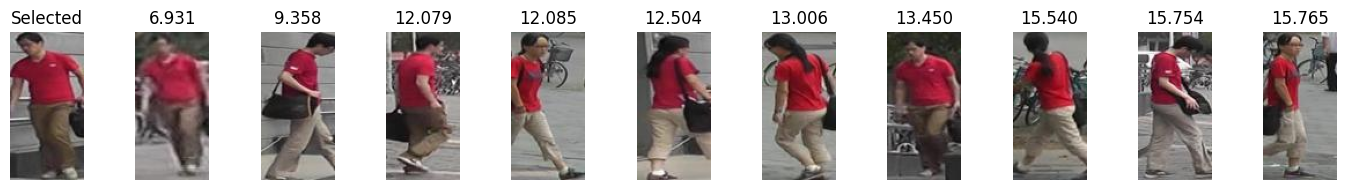

In [ ]:
model = load_triplet_model(margin=10, device=device)
get_top10_triplet(model, data_df, all_data_ds, all_data_loader, device)

# Fisher Models

## Hyperparametr

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_space_dimension = 128
feature_space_dimension = 64
num_epochs = 20
checkpoint_path = model_config_dir

## Utils

In [ ]:
def plot_loss(training_loss , val_loss):

    epoch_count = range(1, len(training_loss) + 1)

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, val_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [ ]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

def load_efficientnet_model(embedding_size):

    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

    in_features = model.classifier[1].in_features  # Get the input features of the final layer
    model.classifier[1] = torch.nn.Linear(in_features, embedding_size)

    model.eval()
    return model

## Fisher Discriminant Contrastive (FDC)

### utils

In [ ]:
def load_fisher_contrastive_model(margin, device):
    backbone = load_efficientnet_model(latent_space_dimension).to(device)
    siamese_model = FDCSiameseNetwork(backbone, feature_space_dimension, latent_space_dimension).to(device)
    siamese_model.load_state_dict(torch.load(os.path.join(model_config_dir, f'best_model_fisher_contrastive_m{margin}.pth')))
    return siamese_model

In [ ]:
class FDCSiameseNetwork(nn.Module):
    def __init__(self, backbone, feature_space_dimension, latent_space_dimension):
        super(FDCSiameseNetwork, self).__init__()
        self.backbone = backbone
        self.last_fc = torch.nn.Linear(latent_space_dimension, feature_space_dimension)

    def forward_one(self, x):
        backbone_output = self.backbone(x)

        feature_output = self.last_fc(backbone_output)
        return backbone_output, feature_output

    def forward(self, input1, input2):
        backbone_output_1, feature_output_1 = self.forward_one(input1)
        backbone_output_2, feature_output_2 = self.forward_one(input2)

        return backbone_output_1, backbone_output_2

In [ ]:
class FDCLoss(nn.Module):
    def __init__(self, margin):
        super(FDCLoss, self).__init__()
        self.margin = margin

    def forward(self, backbone_output_1, backbone_output_2, label, U):
        epsilon_Sw, epsilon_Sb = 0.0001, 0.0001
        lambda_ = 0.01

        bool_label = label.bool()
        o1_secondToLast_positive = backbone_output_1[~bool_label]
        o2_secondToLast_positive = backbone_output_2[~bool_label]
        o1_secondToLast_negative = backbone_output_1[bool_label]
        o3_secondToLast_negative = backbone_output_2[bool_label]

        # calculation of within scatter:
        temp1 = o1_secondToLast_positive - o2_secondToLast_positive
        S_within = torch.matmul(temp1.t(), temp1)

        # calculation of between scatter:
        temp2 = o1_secondToLast_negative - o3_secondToLast_negative
        S_between = torch.matmul(temp2.t(), temp2)

        # strengthen main diagonal of S_within and S_between:
        I_matrix = torch.eye(S_within.size(0)).to(U.device)
        I_matrix_Sw = epsilon_Sw * I_matrix
        I_matrix_Sb = epsilon_Sb * I_matrix
        S_within = S_within + I_matrix_Sw
        S_between = S_between + I_matrix_Sb

        # calculation of variance of projection considering within scatter:
        temp3 = torch.matmul(U.t(), torch.matmul(S_within, U))
        within_scatter_term = torch.trace(temp3)

        # calculation of variance of projection considering between scatter:
        temp4 = torch.matmul(U.t(), torch.matmul(S_between, U))
        between_scatter_term = torch.trace(temp4)

        # calculation of loss:
        loss = ((2 - lambda_) * within_scatter_term) + F.relu(self.margin - (lambda_ * between_scatter_term))

        return loss

In [ ]:
def train_siamese_FDC_loss(model, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs=10):
    best_val_loss = float('inf')
    train_loss_epoch = []
    val_loss_epoch = []

    for epoch in range(num_epochs):
        total_loss_train = 0.0
        total_loss_val = 0.0

        # Training
        model.train()
        train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Training')

        for batch_idx, (pair0 ,pair1 , labels) in train_pbar:

            pair0 ,pair1 , labels = pair0.to(device),pair1.to(device), labels.to(device)
            optimizer.zero_grad()

            backbone_output_1, backbone_output_2 = model(pair0 ,pair1)
            U = model.last_fc.weight.t()  # last fc layer weights
            loss = criterion(backbone_output_1, backbone_output_2, labels, U)
            loss.backward()
            optimizer.step()
            total_loss_train += loss.item()
            train_pbar.set_postfix({'Loss': total_loss_train / (batch_idx + 1)})
            average_loss_train = total_loss_train / (batch_idx + 1)


        train_loss_epoch.append(average_loss_train)
        print(f'Training Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_train:.4f}')

        # Validation
        model.eval()
        with torch.no_grad():
            val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Validation')

            for batch_idx, (pair0 ,pair1 , labels) in val_pbar:
                pair0 ,pair1 , labels = pair0.to(device),pair1.to(device), labels.to(device)

                backbone_output_1, backbone_output_2 = model(pair0 ,pair1)
                U = model.last_fc.weight.t()  # last fc layer weights
                val_loss = criterion(backbone_output_1, backbone_output_2, labels, U)
                total_loss_val += val_loss.item()

                val_pbar.set_postfix({'Validation Loss': total_loss_val / (batch_idx + 1)})
                average_loss_val =  total_loss_val / (batch_idx + 1)

        val_loss_epoch.append(average_loss_val)
        print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_val:.4f}')

        # LR Scheduler
        scheduler.step()

        # Save the model if the validation loss is the best so far
        if average_loss_val < best_val_loss:
            best_val_loss = average_loss_val
            torch.save(model.state_dict(), os.path.join(checkpoint_path , f'best_model_fisher_contrastive_m{margin}.pth'))
            print(f'Model saved with best validation loss: {best_val_loss:.4f}')

    return model , train_loss_epoch , val_loss_epoch

In [ ]:
def evaluate_siamese(model, test_loader, threshold=0.9):
    model.eval()

    total_pairs = 0
    distances = []
    labels = []

    with torch.no_grad():
        for batch_idx, (pair0 ,pair1 , label) in enumerate(test_loader):
            pair0 ,pair1 , label = pair0.to(device),pair1.to(device), label.to(device)

            output0, output1 = model(pair0 ,pair1)

            euclidean_distance = F.pairwise_distance(output0, output1)
            distances += euclidean_distance
            labels += label

            total_pairs += label.size(0)

        distances = torch.stack(distances)
        labels = torch.stack(labels)

        distances_min, _ = torch.min(distances,0)
        distances_max, _ = torch.max(distances,0)

        distances = (distances - distances_min) / (distances_max - distances_min)

        predictions = (distances < threshold).float()

        true_positive = sum((predictions == 1) & (labels == 0))
        false_positive = sum((predictions == 1) & (labels == 1))

    tpr = true_positive / total_pairs
    fpr = false_positive / total_pairs

    return tpr, fpr

### Margin = 0.1

In [ ]:
margin = 0.1

backbone = load_efficientnet_model(latent_space_dimension).to(device)
siamese_model = FDCSiameseNetwork(backbone, feature_space_dimension, latent_space_dimension).to(device)

criterion = FDCLoss(margin)

optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
siamese_model , train_loss_epoch , val_loss_epoch = train_siamese_FDC_loss(
    siamese_model, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.59it/s, Loss=7.2]


Training Epoch [1/20], Average Loss: 7.1976


Epoch 1/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.68it/s, Validation Loss=0.193]


Validation Epoch [1/20], Average Loss: 0.1934
Model saved with best validation loss: 0.1934


Epoch 2/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.70it/s, Loss=0.346]


Training Epoch [2/20], Average Loss: 0.3457


Epoch 2/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.17it/s, Validation Loss=0.123]


Validation Epoch [2/20], Average Loss: 0.1229
Model saved with best validation loss: 0.1229


Epoch 3/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.75it/s, Loss=0.173]


Training Epoch [3/20], Average Loss: 0.1729


Epoch 3/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.47it/s, Validation Loss=0.11]


Validation Epoch [3/20], Average Loss: 0.1099
Model saved with best validation loss: 0.1099


Epoch 4/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.66it/s, Loss=0.135]


Training Epoch [4/20], Average Loss: 0.1346


Epoch 4/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.75it/s, Validation Loss=0.106]


Validation Epoch [4/20], Average Loss: 0.1063
Model saved with best validation loss: 0.1063


Epoch 5/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.70it/s, Loss=0.12]


Training Epoch [5/20], Average Loss: 0.1202


Epoch 5/20 - Validation: 100%|██████████| 47/47 [00:04<00:00, 11.36it/s, Validation Loss=0.104]


Validation Epoch [5/20], Average Loss: 0.1040
Model saved with best validation loss: 0.1040


Epoch 6/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.61it/s, Loss=0.113]


Training Epoch [6/20], Average Loss: 0.1132


Epoch 6/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.61it/s, Validation Loss=0.103]


Validation Epoch [6/20], Average Loss: 0.1031
Model saved with best validation loss: 0.1031


Epoch 7/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.57it/s, Loss=0.109]


Training Epoch [7/20], Average Loss: 0.1094


Epoch 7/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.69it/s, Validation Loss=0.103]


Validation Epoch [7/20], Average Loss: 0.1026
Model saved with best validation loss: 0.1026


Epoch 8/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.69it/s, Loss=0.107]


Training Epoch [8/20], Average Loss: 0.1071


Epoch 8/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.72it/s, Validation Loss=0.102]


Validation Epoch [8/20], Average Loss: 0.1023
Model saved with best validation loss: 0.1023


Epoch 9/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.59it/s, Loss=0.106]


Training Epoch [9/20], Average Loss: 0.1056


Epoch 9/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.21it/s, Validation Loss=0.102]


Validation Epoch [9/20], Average Loss: 0.1021
Model saved with best validation loss: 0.1021


Epoch 10/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.73it/s, Loss=0.105]


Training Epoch [10/20], Average Loss: 0.1046


Epoch 10/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.39it/s, Validation Loss=0.102]


Validation Epoch [10/20], Average Loss: 0.1019
Model saved with best validation loss: 0.1019


Epoch 11/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.39it/s, Loss=0.104]


Training Epoch [11/20], Average Loss: 0.1041


Epoch 11/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.68it/s, Validation Loss=0.102]


Validation Epoch [11/20], Average Loss: 0.1019
Model saved with best validation loss: 0.1019


Epoch 12/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.69it/s, Loss=0.104]


Training Epoch [12/20], Average Loss: 0.1041


Epoch 12/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.19it/s, Validation Loss=0.102]


Validation Epoch [12/20], Average Loss: 0.1019
Model saved with best validation loss: 0.1019


Epoch 13/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.63it/s, Loss=0.104]


Training Epoch [13/20], Average Loss: 0.1040


Epoch 13/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.71it/s, Validation Loss=0.102]


Validation Epoch [13/20], Average Loss: 0.1019
Model saved with best validation loss: 0.1019


Epoch 14/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.72it/s, Loss=0.104]


Training Epoch [14/20], Average Loss: 0.1039


Epoch 14/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 11.97it/s, Validation Loss=0.102]


Validation Epoch [14/20], Average Loss: 0.1018
Model saved with best validation loss: 0.1018


Epoch 15/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.67it/s, Loss=0.104]


Training Epoch [15/20], Average Loss: 0.1038


Epoch 15/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.01it/s, Validation Loss=0.102]


Validation Epoch [15/20], Average Loss: 0.1018
Model saved with best validation loss: 0.1018


Epoch 16/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.68it/s, Loss=0.104]


Training Epoch [16/20], Average Loss: 0.1036


Epoch 16/20 - Validation: 100%|██████████| 47/47 [00:04<00:00, 11.48it/s, Validation Loss=0.102]


Validation Epoch [16/20], Average Loss: 0.1018
Model saved with best validation loss: 0.1018


Epoch 17/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.67it/s, Loss=0.103]


Training Epoch [17/20], Average Loss: 0.1035


Epoch 17/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.23it/s, Validation Loss=0.102]


Validation Epoch [17/20], Average Loss: 0.1018
Model saved with best validation loss: 0.1018


Epoch 18/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.39it/s, Loss=0.103]


Training Epoch [18/20], Average Loss: 0.1034


Epoch 18/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.56it/s, Validation Loss=0.102]


Validation Epoch [18/20], Average Loss: 0.1018
Model saved with best validation loss: 0.1018


Epoch 19/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.61it/s, Loss=0.103]


Training Epoch [19/20], Average Loss: 0.1032


Epoch 19/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.50it/s, Validation Loss=0.102]


Validation Epoch [19/20], Average Loss: 0.1017
Model saved with best validation loss: 0.1017


Epoch 20/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.43it/s, Loss=0.103]


Training Epoch [20/20], Average Loss: 0.1030


Epoch 20/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.37it/s, Validation Loss=0.102]


Validation Epoch [20/20], Average Loss: 0.1017
Model saved with best validation loss: 0.1017


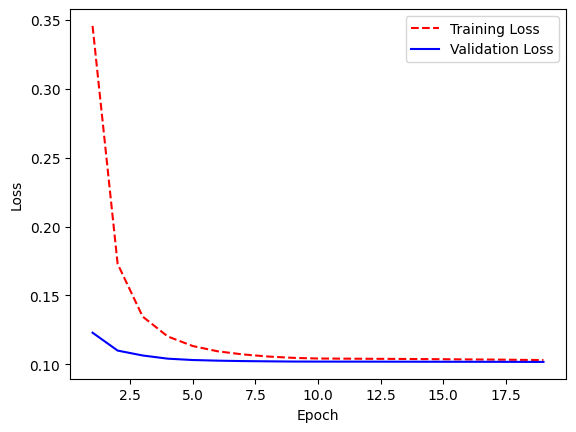

In [ ]:
plot_loss(train_loss_epoch[1:] , val_loss_epoch[1:])

In [ ]:
siamese_model = load_fisher_contrastive_model(margin=0.1, device=device)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(siamese_model, train_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4914
False Positive Rate (FPR) for threshold 0.5: 0.4912
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1233
False Positive Rate (FPR) for threshold 0.1: 0.0854
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0005
False Positive Rate (FPR) for threshold 0.01: 0.0000
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(siamese_model, test_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4914
False Positive Rate (FPR) for threshold 0.5: 0.4912
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1233
False Positive Rate (FPR) for threshold 0.1: 0.0854
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0005
False Positive Rate (FPR) for threshold 0.01: 0.0000
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


#### get top

100%|██████████| 102/102 [00:12<00:00,  8.37it/s]


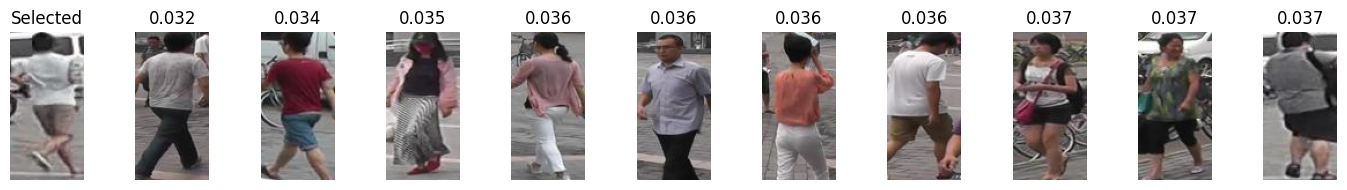

In [ ]:
get_top10(siamese_model, data_df, all_data_ds, all_data_loader, device)

### Margin = 1

In [ ]:
margin = 1

backbone = load_efficientnet_model(latent_space_dimension).to(device)
siamese_model = FDCSiameseNetwork(backbone, feature_space_dimension, latent_space_dimension).to(device)

criterion = FDCLoss(margin)

optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [ ]:
siamese_model , train_loss_epoch , val_loss_epoch = train_siamese_FDC_loss(
    siamese_model, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.66it/s, Loss=8.16]


Training Epoch [1/20], Average Loss: 8.1556


Epoch 1/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.18it/s, Validation Loss=1.09]


Validation Epoch [1/20], Average Loss: 1.0856
Model saved with best validation loss: 1.0856


Epoch 2/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.43it/s, Loss=1.26]


Training Epoch [2/20], Average Loss: 1.2585


Epoch 2/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.50it/s, Validation Loss=1.02]


Validation Epoch [2/20], Average Loss: 1.0236
Model saved with best validation loss: 1.0236


Epoch 3/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.44it/s, Loss=1.09]


Training Epoch [3/20], Average Loss: 1.0894


Epoch 3/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.10it/s, Validation Loss=1.01]


Validation Epoch [3/20], Average Loss: 1.0103
Model saved with best validation loss: 1.0103


Epoch 4/20 - Training: 100%|██████████| 372/372 [00:52<00:00,  7.10it/s, Loss=1.04]


Training Epoch [4/20], Average Loss: 1.0426


Epoch 4/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.95it/s, Validation Loss=1.01]


Validation Epoch [4/20], Average Loss: 1.0061
Model saved with best validation loss: 1.0061


Epoch 5/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.44it/s, Loss=1.03]


Training Epoch [5/20], Average Loss: 1.0260


Epoch 5/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.35it/s, Validation Loss=1]


Validation Epoch [5/20], Average Loss: 1.0043
Model saved with best validation loss: 1.0043


Epoch 6/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.57it/s, Loss=1.02]


Training Epoch [6/20], Average Loss: 1.0169


Epoch 6/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.78it/s, Validation Loss=1]


Validation Epoch [6/20], Average Loss: 1.0033
Model saved with best validation loss: 1.0033


Epoch 7/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.42it/s, Loss=1.01]


Training Epoch [7/20], Average Loss: 1.0121


Epoch 7/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.02it/s, Validation Loss=1]


Validation Epoch [7/20], Average Loss: 1.0026
Model saved with best validation loss: 1.0026


Epoch 8/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.51it/s, Loss=1.01]


Training Epoch [8/20], Average Loss: 1.0090


Epoch 8/20 - Validation: 100%|██████████| 47/47 [00:04<00:00, 11.35it/s, Validation Loss=1]


Validation Epoch [8/20], Average Loss: 1.0023
Model saved with best validation loss: 1.0023


Epoch 9/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.56it/s, Loss=1.01]


Training Epoch [9/20], Average Loss: 1.0077


Epoch 9/20 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.69it/s, Validation Loss=1]


Validation Epoch [9/20], Average Loss: 1.0022
Model saved with best validation loss: 1.0022


Epoch 10/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.43it/s, Loss=1.01]


Training Epoch [10/20], Average Loss: 1.0075


Epoch 10/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.21it/s, Validation Loss=1]


Validation Epoch [10/20], Average Loss: 1.0021
Model saved with best validation loss: 1.0021


Epoch 11/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.52it/s, Loss=1.01]


Training Epoch [11/20], Average Loss: 1.0071


Epoch 11/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.37it/s, Validation Loss=1]


Validation Epoch [11/20], Average Loss: 1.0021
Model saved with best validation loss: 1.0021


Epoch 12/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.51it/s, Loss=1.01]


Training Epoch [12/20], Average Loss: 1.0070


Epoch 12/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.47it/s, Validation Loss=1]


Validation Epoch [12/20], Average Loss: 1.0021
Model saved with best validation loss: 1.0021


Epoch 13/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.46it/s, Loss=1.01]


Training Epoch [13/20], Average Loss: 1.0067


Epoch 13/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.27it/s, Validation Loss=1]


Validation Epoch [13/20], Average Loss: 1.0020
Model saved with best validation loss: 1.0020


Epoch 14/20 - Training: 100%|██████████| 372/372 [00:52<00:00,  7.12it/s, Loss=1.01]


Training Epoch [14/20], Average Loss: 1.0063


Epoch 14/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.16it/s, Validation Loss=1]


Validation Epoch [14/20], Average Loss: 1.0020
Model saved with best validation loss: 1.0020


Epoch 15/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.35it/s, Loss=1.01]


Training Epoch [15/20], Average Loss: 1.0060


Epoch 15/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.10it/s, Validation Loss=1]


Validation Epoch [15/20], Average Loss: 1.0019
Model saved with best validation loss: 1.0019


Epoch 16/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.56it/s, Loss=1.01]


Training Epoch [16/20], Average Loss: 1.0056


Epoch 16/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.20it/s, Validation Loss=1]


Validation Epoch [16/20], Average Loss: 1.0019
Model saved with best validation loss: 1.0019


Epoch 17/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.46it/s, Loss=1.01]


Training Epoch [17/20], Average Loss: 1.0054


Epoch 17/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.30it/s, Validation Loss=1]


Validation Epoch [17/20], Average Loss: 1.0018
Model saved with best validation loss: 1.0018


Epoch 18/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.36it/s, Loss=1.01]


Training Epoch [18/20], Average Loss: 1.0054


Epoch 18/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.46it/s, Validation Loss=1]


Validation Epoch [18/20], Average Loss: 1.0018
Model saved with best validation loss: 1.0018


Epoch 19/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.48it/s, Loss=1.01]


Training Epoch [19/20], Average Loss: 1.0054


Epoch 19/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.43it/s, Validation Loss=1]


Validation Epoch [19/20], Average Loss: 1.0018


Epoch 20/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.33it/s, Loss=1.01]


Training Epoch [20/20], Average Loss: 1.0053


Epoch 20/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.41it/s, Validation Loss=1]

Validation Epoch [20/20], Average Loss: 1.0018


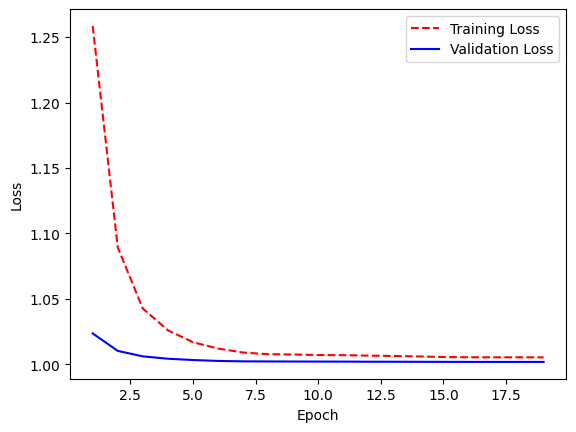

In [ ]:
plot_loss(train_loss_epoch , val_loss_epoch)

In [ ]:
siamese_model = load_fisher_contrastive_model(margin=1, device=device)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(siamese_model, train_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4768
False Positive Rate (FPR) for threshold 0.5: 0.4756
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1570
False Positive Rate (FPR) for threshold 0.1: 0.1198
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0003
False Positive Rate (FPR) for threshold 0.01: 0.0000
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(siamese_model, test_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4837
False Positive Rate (FPR) for threshold 0.5: 0.4830
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1753
False Positive Rate (FPR) for threshold 0.1: 0.1417
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0005
False Positive Rate (FPR) for threshold 0.01: 0.0000
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


#### get top

100%|██████████| 102/102 [00:12<00:00,  8.27it/s]


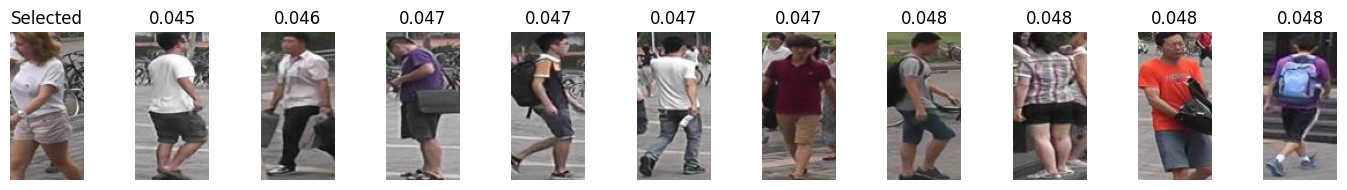

In [ ]:
get_top10(siamese_model, data_df, all_data_ds, all_data_loader, device)

### Margin = 10

In [ ]:
margin = 10

backbone = load_efficientnet_model(latent_space_dimension).to(device)
siamese_model = FDCSiameseNetwork(backbone, feature_space_dimension, latent_space_dimension).to(device)

criterion = FDCLoss(margin)

optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
siamese_model , train_loss_epoch , val_loss_epoch = train_siamese_FDC_loss(
    siamese_model, train_loader, val_loader, criterion, optimizer, scheduler, checkpoint_path, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.58it/s, Loss=16.5]


Training Epoch [1/20], Average Loss: 16.5433


Epoch 1/20 - Validation: 100%|██████████| 47/47 [00:04<00:00, 11.27it/s, Validation Loss=10.1]


Validation Epoch [1/20], Average Loss: 10.0895
Model saved with best validation loss: 10.0895


Epoch 2/20 - Training: 100%|██████████| 372/372 [00:48<00:00,  7.61it/s, Loss=10.3]


Training Epoch [2/20], Average Loss: 10.2552


Epoch 2/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.17it/s, Validation Loss=10]


Validation Epoch [2/20], Average Loss: 10.0252
Model saved with best validation loss: 10.0252


Epoch 3/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.45it/s, Loss=10.1]


Training Epoch [3/20], Average Loss: 10.0910


Epoch 3/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.36it/s, Validation Loss=10]


Validation Epoch [3/20], Average Loss: 10.0102
Model saved with best validation loss: 10.0102


Epoch 4/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.59it/s, Loss=10]


Training Epoch [4/20], Average Loss: 10.0430


Epoch 4/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.80it/s, Validation Loss=10]


Validation Epoch [4/20], Average Loss: 10.0056
Model saved with best validation loss: 10.0056


Epoch 5/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.36it/s, Loss=10]


Training Epoch [5/20], Average Loss: 10.0241


Epoch 5/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.45it/s, Validation Loss=10]


Validation Epoch [5/20], Average Loss: 10.0038
Model saved with best validation loss: 10.0038


Epoch 6/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.32it/s, Loss=10]


Training Epoch [6/20], Average Loss: 10.0151


Epoch 6/20 - Validation: 100%|██████████| 47/47 [00:04<00:00, 11.36it/s, Validation Loss=10]


Validation Epoch [6/20], Average Loss: 10.0028
Model saved with best validation loss: 10.0028


Epoch 7/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.32it/s, Loss=10]


Training Epoch [7/20], Average Loss: 10.0107


Epoch 7/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.12it/s, Validation Loss=10]


Validation Epoch [7/20], Average Loss: 10.0023
Model saved with best validation loss: 10.0023


Epoch 8/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.39it/s, Loss=10]


Training Epoch [8/20], Average Loss: 10.0077


Epoch 8/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.47it/s, Validation Loss=10]


Validation Epoch [8/20], Average Loss: 10.0020
Model saved with best validation loss: 10.0020


Epoch 9/20 - Training: 100%|██████████| 372/372 [00:52<00:00,  7.13it/s, Loss=10]


Training Epoch [9/20], Average Loss: 10.0059


Epoch 9/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.40it/s, Validation Loss=10]


Validation Epoch [9/20], Average Loss: 10.0018
Model saved with best validation loss: 10.0018


Epoch 10/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.50it/s, Loss=10]


Training Epoch [10/20], Average Loss: 10.0048


Epoch 10/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.47it/s, Validation Loss=10]


Validation Epoch [10/20], Average Loss: 10.0017
Model saved with best validation loss: 10.0017


Epoch 11/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.47it/s, Loss=10]


Training Epoch [11/20], Average Loss: 10.0041


Epoch 11/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 12.90it/s, Validation Loss=10]


Validation Epoch [11/20], Average Loss: 10.0017
Model saved with best validation loss: 10.0017


Epoch 12/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.49it/s, Loss=10]


Training Epoch [12/20], Average Loss: 10.0040


Epoch 12/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.79it/s, Validation Loss=10]


Validation Epoch [12/20], Average Loss: 10.0016
Model saved with best validation loss: 10.0016


Epoch 13/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.39it/s, Loss=10]


Training Epoch [13/20], Average Loss: 10.0039


Epoch 13/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.52it/s, Validation Loss=10]


Validation Epoch [13/20], Average Loss: 10.0016


Epoch 14/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.54it/s, Loss=10]


Training Epoch [14/20], Average Loss: 10.0038


Epoch 14/20 - Validation: 100%|██████████| 47/47 [00:04<00:00, 11.28it/s, Validation Loss=10]


Validation Epoch [14/20], Average Loss: 10.0016
Model saved with best validation loss: 10.0016


Epoch 15/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.54it/s, Loss=10]


Training Epoch [15/20], Average Loss: 10.0037


Epoch 15/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.66it/s, Validation Loss=10]


Validation Epoch [15/20], Average Loss: 10.0016
Model saved with best validation loss: 10.0016


Epoch 16/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.43it/s, Loss=10]


Training Epoch [16/20], Average Loss: 10.0036


Epoch 16/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 14.34it/s, Validation Loss=10]


Validation Epoch [16/20], Average Loss: 10.0016
Model saved with best validation loss: 10.0016


Epoch 17/20 - Training: 100%|██████████| 372/372 [00:49<00:00,  7.48it/s, Loss=10]


Training Epoch [17/20], Average Loss: 10.0034


Epoch 17/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 13.69it/s, Validation Loss=10]


Validation Epoch [17/20], Average Loss: 10.0015
Model saved with best validation loss: 10.0015


Epoch 18/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.36it/s, Loss=10]


Training Epoch [18/20], Average Loss: 10.0032


Epoch 18/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.30it/s, Validation Loss=10]


Validation Epoch [18/20], Average Loss: 10.0015
Model saved with best validation loss: 10.0015


Epoch 19/20 - Training: 100%|██████████| 372/372 [00:51<00:00,  7.19it/s, Loss=10]


Training Epoch [19/20], Average Loss: 10.0031


Epoch 19/20 - Validation: 100%|██████████| 47/47 [00:04<00:00,  9.57it/s, Validation Loss=10]


Validation Epoch [19/20], Average Loss: 10.0015
Model saved with best validation loss: 10.0015


Epoch 20/20 - Training: 100%|██████████| 372/372 [00:50<00:00,  7.41it/s, Loss=10]


Training Epoch [20/20], Average Loss: 10.0029


Epoch 20/20 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.32it/s, Validation Loss=10]


Validation Epoch [20/20], Average Loss: 10.0014
Model saved with best validation loss: 10.0014


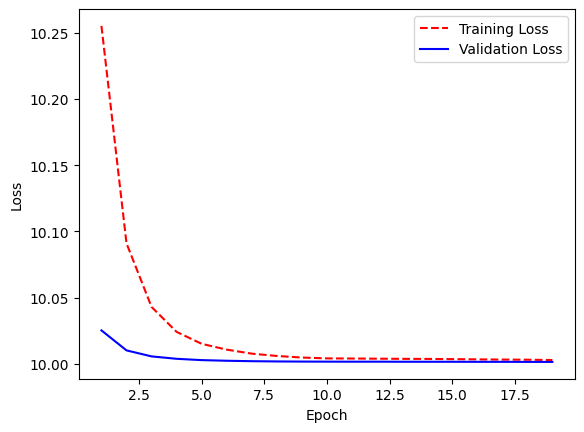

In [ ]:
plot_loss(train_loss_epoch[1:] , val_loss_epoch[1:])

In [ ]:
siamese_model = load_fisher_contrastive_model(margin=10, device=device)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(siamese_model, train_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4918
False Positive Rate (FPR) for threshold 0.5: 0.4938
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1897
False Positive Rate (FPR) for threshold 0.1: 0.1486
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0004
False Positive Rate (FPR) for threshold 0.01: 0.0002
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese(siamese_model, test_loader , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.4918
False Positive Rate (FPR) for threshold 0.5: 0.4938
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.1897
False Positive Rate (FPR) for threshold 0.1: 0.1486
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0004
False Positive Rate (FPR) for threshold 0.01: 0.0002
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0000
*********************************


#### get top

100%|██████████| 102/102 [00:12<00:00,  8.38it/s]


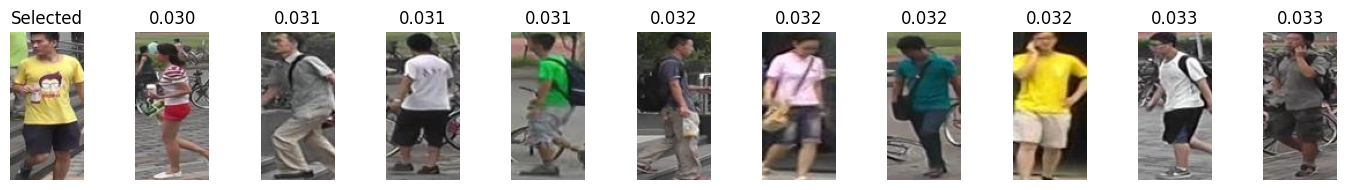

In [ ]:
get_top10(siamese_model, data_df, all_data_ds, all_data_loader, device)

## Fisher Discriminant Triplet (FDT)

### utils

In [ ]:
def load_FDT_triplet_model(margin, device):
    base_model = load_efficientnet_model(latent_space_dimension).to(device)
    siamese_model_triplet = FDTSiameseNetworkTriplet(base_model, latent_space_dimension, feature_space_dimension).to(device)
    siamese_model_triplet.load_state_dict(torch.load(os.path.join(model_config_dir, f'best_model_fisher_triplet_m{margin}.pth')))
    return siamese_model_triplet

In [ ]:
class FDTSiameseNetworkTriplet(nn.Module):
    def __init__(self, base_model, latent_space_dimension, feature_space_dimension):
        super(FDTSiameseNetworkTriplet, self).__init__()
        self.base_model = base_model
        self.last_fc = torch.nn.Linear(latent_space_dimension, feature_space_dimension)

    def forward_one(self, x):
        backbone_output = self.base_model(x)
        feature_output = self.last_fc(backbone_output)
        return backbone_output, feature_output

    def forward(self, anchor, positive , negative):
        backbone_anchor, out_anchor = self.forward_one(anchor)
        backbone_pos, out_pos = self.forward_one(positive)
        backbone_neg, out_neg = self.forward_one(negative)
        return backbone_anchor, backbone_pos, backbone_neg

In [ ]:
class FDTTripletLoss(nn.Module):
    def __init__(self, margin):
        super(FDTTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, U):
        epsilon_Sw, epsilon_Sb = 0.0001, 0.0001
        lambda_ = 0.01

        # calculation of within scatter:
        temp1 = anchor - positive
        S_within = torch.matmul(temp1.t(), temp1)

        # calculation of between scatter:
        temp2 = anchor - negative
        S_between = torch.matmul(temp2.t(), temp2)

        # strengthen main diagonal of S_within and S_between:
        I_matrix = torch.eye(S_within.size(0)).to(S_within.device)
        I_matrix_Sw = epsilon_Sw * I_matrix
        I_matrix_Sb = epsilon_Sb * I_matrix
        S_within = S_within + I_matrix_Sw
        S_between = S_between + I_matrix_Sb

        # calculation of variance of projection considering within scatter:
        temp3 = torch.matmul(U.t(), torch.matmul(S_within, U))
        within_scatter_term = torch.trace(temp3)

        # calculation of variance of projection considering between scatter:
        temp4 = torch.matmul(U.t(), torch.matmul(S_between, U))
        between_scatter_term = torch.trace(temp4)

        # calculation of loss:
        loss_ = self.margin + ((2 - lambda_) * within_scatter_term) - (lambda_ * between_scatter_term)
        loss = torch.nn.functional.relu(loss_)
        return loss

In [ ]:
def train_siamese_FDT_triplet_loss(model, train_loader, val_loader, criterion, optimizer,scheduler,  checkpoint_path,margin, num_epochs=10):
    best_val_loss = float('inf')
    train_loss_epoch = []
    val_loss_epoch = []


    for epoch in range(num_epochs):
        total_loss_train = 0.0
        total_loss_val = 0.0

        # Training
        model.train()
        train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Training')

        for batch_idx, (anchor ,positive , negative) in train_pbar:

            anchor ,positive , negative= anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()

            out_anchor, out_pos, out_neg = model(anchor ,positive , negative)
            U = model.last_fc.weight.t()
            loss = criterion(out_anchor, out_pos, out_neg, U)

            loss.backward()
            optimizer.step()
            total_loss_train += loss.item()
            train_pbar.set_postfix({'Loss': total_loss_train / (batch_idx + 1)})


        average_loss_train = total_loss_train / len(train_loader.dataset)
        train_loss_epoch.append(average_loss_train)
        print(f'Training Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_train:.4f}')

        # Validation
        model.eval()
        with torch.no_grad():
            val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Epoch {epoch+1}/{num_epochs} - Validation')

            for batch_idx, (anchor ,positive , negative) in val_pbar:
                anchor ,positive , negative= anchor.to(device), positive.to(device), negative.to(device)
                out_anchor, out_pos, out_neg = model(anchor ,positive , negative)
                U = model.last_fc.weight.t()
                val_loss = criterion(out_anchor, out_pos, out_neg, U)
                total_loss_val += val_loss.item()
                val_pbar.set_postfix({'Validation Loss': total_loss_val / (batch_idx+1)})

        average_loss_val = total_loss_val / len(val_loader.dataset)
        val_loss_epoch.append(average_loss_val)
        print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss_val:.4f}')

        scheduler.step()

        # Save the model if the validation loss is the best so far
        if average_loss_val < best_val_loss:
            best_val_loss = average_loss_val
            torch.save(model.state_dict(), os.path.join(checkpoint_path , f'best_model_fisher_triplet_m{margin}.pth'))
            print(f'Model saved with best validation loss: {best_val_loss:.4f}')



    return model , train_loss_epoch , val_loss_epoch

In [ ]:
def evaluate_siamese_triplet(model, test_loader, threshold=0.9):
    model.eval()
    true_positive = 0
    false_positive = 0
    total_pairs = 0
    pos_dists =[]
    neg_dists =[]

    with torch.no_grad():
        for batch_idx, (anchor ,positive , negative) in enumerate(test_loader):
            anchor ,positive , negative = anchor.to(device),positive.to(device), negative.to(device)

            out_anchor ,out_positive , out_negative = model(anchor ,positive , negative)


            euclidean_distance_pos = F.pairwise_distance(out_anchor, out_positive)
            euclidean_distance_neg = F.pairwise_distance(out_anchor, out_negative)

            pos_dists += euclidean_distance_pos
            neg_dists += euclidean_distance_neg

        pos_dists = torch.stack(pos_dists)
        neg_dists = torch.stack(neg_dists)

        p_min_dist, _ = torch.min(pos_dists,0)
        n_min_dist, _ = torch.min(neg_dists,0)
        p_max_dist, _ = torch.max(pos_dists,0)
        n_max_dist, _ = torch.max(neg_dists,0)

        pos_dists = (pos_dists - p_min_dist) / (p_max_dist - p_min_dist)
        neg_dists = (neg_dists - n_min_dist) / (n_max_dist - n_min_dist)



    return sum(pos_dists < threshold) / pos_dists.shape[0] , sum(neg_dists < threshold)/ neg_dists.shape[0]

In [ ]:
def get_top10_triplet(model, all_data_df, all_data_ds, all_data_loader, device):
    anchor_idx = np.random.randint(len(all_data_df))
    anchor_img = all_data_ds[anchor_idx]
    anchor_img = anchor_img.unsqueeze(dim=0).to(device)

    distances = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (img) in enumerate(tqdm(all_data_loader)):
            img = img.to(device)
            output0 = model.base_model(anchor_img)
            output1 = model.base_model(img)
            euclidean_distance = F.pairwise_distance(output0, output1)
            distances.append(euclidean_distance)

    distances = torch.concat(distances)

    top10 = torch.topk(distances, k=11, largest=False)  # first one is the Anchor image
    fig, axs = plt.subplots(1, 11, figsize=(14, 2))

    axs[0].imshow(Image.open(data_df.iloc[anchor_idx, 0]), cmap='viridis')
    axs[0].axis('off')
    axs[0].set_title("Selected")

    for i in range(1, len(top10.indices)):
        neighbor_idx = top10.indices[i].detach().cpu().item()
        neighbor_dist = top10.values[i].detach().cpu().item()
        axs[i].imshow(Image.open(all_data_df.iloc[neighbor_idx, 0]), cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f"{neighbor_dist:.3f}")

    plt.tight_layout()
    plt.show()

### preparing data

In [ ]:
from PIL import Image


class SiameseDatasetTriplet(Dataset):
    def __init__(self,triplets, transform=None):
        self.transform = transform
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        triple = self.triplets[idx]
        anchor = triple[0]
        positive = triple[1][0]
        negative = triple[2][0]

        anchor_img = Image.open(anchor).convert("RGB") # Reading image
        pos_img = Image.open(positive).convert("RGB") # Reading image
        neg_img = Image.open(negative).convert("RGB") # Reading image

        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anchor_img , pos_img , neg_img

In [ ]:
from random import shuffle

def generate_triplets(df ,num_triplet , anchor_id):
    triplets = []
    positive_paths = df[df['id'] == anchor_id]['path']
    negative_paths = df[df['id'] != anchor_id]['path']

    positive_pairs = list(itertools.combinations(positive_paths, 2))

    if num_triplet > len(positive_pairs):
        for pair in positive_pairs:
            anchor = pair[0]
            positive = pair[1]
            negative = negative_paths.sample(1).values[0]
            triplets.append([anchor , [positive, 0] , [negative,1]])

    else:
        shuffle(positive_pairs)
        for i in range(num_triplet):
            anchor = positive_pairs[i][0]
            positive =  positive_pairs[i][1]
            negative = negative_paths.sample(1).values[0]
            triplets.append([anchor , [positive, 0] , [negative,1]])

    return triplets

In [ ]:
total_triplets= []
for id in data_df['id'].unique():
    total_triplets.append(generate_triplets(data_df , 20 , anchor_id = id))


In [ ]:
total_triplets = [
    x
    for xs in total_triplets
    for x in xs
]

In [ ]:
train_df_triplet, test_df_triplet = train_test_split(total_triplets, test_size=0.2, random_state=42, shuffle=True)
test_df_triplet, val_df_triplet = train_test_split(test_df_triplet, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
len(train_df_triplet) , len(val_df_triplet) , len(test_df_triplet)

(11328, 1417, 1416)

In [ ]:
train_ds_triplet = SiameseDatasetTriplet(triplets=train_df_triplet, transform=data_transforms)
val_ds_triplet = SiameseDatasetTriplet(triplets=val_df_triplet, transform=data_transforms)
test_ds_triplet = SiameseDatasetTriplet(triplets=test_df_triplet, transform=data_transforms)

train_loader_triplet =DataLoader(train_ds_triplet, batch_size=batch_sizes['train'])
val_loader_triplet =DataLoader(val_ds_triplet, batch_size=batch_sizes['val'])
test_loader_triplet =DataLoader(train_ds_triplet, batch_size=batch_sizes['train'])

### Margin = 0.1

In [ ]:
margin = 0.1

base_model = load_efficientnet_model(latent_space_dimension).to(device)
siamese_model_triplet = FDTSiameseNetworkTriplet(base_model, latent_space_dimension, feature_space_dimension).to(device)
criterion = FDTTripletLoss(margin)

optimizer = optim.Adam(siamese_model_triplet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_triplet , train_loss_epoch , val_loss_epoch = train_siamese_FDT_triplet_loss(
    siamese_model_triplet, train_loader_triplet, val_loader_triplet, criterion, optimizer, scheduler, model_config_dir, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.27it/s, Loss=9.12]


Training Epoch [1/20], Average Loss: 0.2851


Epoch 1/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.17it/s, Validation Loss=0.177]


Validation Epoch [1/20], Average Loss: 0.0056
Model saved with best validation loss: 0.0056


Epoch 2/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=0.276]


Training Epoch [2/20], Average Loss: 0.0086


Epoch 2/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.63it/s, Validation Loss=0.117]


Validation Epoch [2/20], Average Loss: 0.0037
Model saved with best validation loss: 0.0037


Epoch 3/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=0.164]


Training Epoch [3/20], Average Loss: 0.0051


Epoch 3/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.07it/s, Validation Loss=0.109]


Validation Epoch [3/20], Average Loss: 0.0035
Model saved with best validation loss: 0.0035


Epoch 4/20 - Training: 100%|██████████| 354/354 [01:10<00:00,  5.00it/s, Loss=0.133]


Training Epoch [4/20], Average Loss: 0.0042


Epoch 4/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.58it/s, Validation Loss=0.105]


Validation Epoch [4/20], Average Loss: 0.0034
Model saved with best validation loss: 0.0034


Epoch 5/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.12]


Training Epoch [5/20], Average Loss: 0.0038


Epoch 5/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.49it/s, Validation Loss=0.104]


Validation Epoch [5/20], Average Loss: 0.0033
Model saved with best validation loss: 0.0033


Epoch 6/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=0.114]


Training Epoch [6/20], Average Loss: 0.0036


Epoch 6/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.22it/s, Validation Loss=0.103]


Validation Epoch [6/20], Average Loss: 0.0033
Model saved with best validation loss: 0.0033


Epoch 7/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.21it/s, Loss=0.111]


Training Epoch [7/20], Average Loss: 0.0035


Epoch 7/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.02it/s, Validation Loss=0.103]


Validation Epoch [7/20], Average Loss: 0.0033
Model saved with best validation loss: 0.0033


Epoch 8/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=0.108]


Training Epoch [8/20], Average Loss: 0.0034


Epoch 8/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.11it/s, Validation Loss=0.103]


Validation Epoch [8/20], Average Loss: 0.0033
Model saved with best validation loss: 0.0033


Epoch 9/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=0.107]


Training Epoch [9/20], Average Loss: 0.0033


Epoch 9/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.21it/s, Validation Loss=0.102]


Validation Epoch [9/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 10/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.106]


Training Epoch [10/20], Average Loss: 0.0033


Epoch 10/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.21it/s, Validation Loss=0.102]


Validation Epoch [10/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 11/20 - Training: 100%|██████████| 354/354 [01:10<00:00,  5.00it/s, Loss=0.105]


Training Epoch [11/20], Average Loss: 0.0033


Epoch 11/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  7.81it/s, Validation Loss=0.102]


Validation Epoch [11/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 12/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=0.105]


Training Epoch [12/20], Average Loss: 0.0033


Epoch 12/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.30it/s, Validation Loss=0.102]


Validation Epoch [12/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 13/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.27it/s, Loss=0.105]


Training Epoch [13/20], Average Loss: 0.0033


Epoch 13/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.21it/s, Validation Loss=0.102]


Validation Epoch [13/20], Average Loss: 0.0032


Epoch 14/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=0.105]


Training Epoch [14/20], Average Loss: 0.0033


Epoch 14/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.17it/s, Validation Loss=0.102]


Validation Epoch [14/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 15/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.27it/s, Loss=0.105]


Training Epoch [15/20], Average Loss: 0.0033


Epoch 15/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.12it/s, Validation Loss=0.102]


Validation Epoch [15/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 16/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.27it/s, Loss=0.104]


Training Epoch [16/20], Average Loss: 0.0033


Epoch 16/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.22it/s, Validation Loss=0.102]


Validation Epoch [16/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 17/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=0.104]


Training Epoch [17/20], Average Loss: 0.0033


Epoch 17/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.47it/s, Validation Loss=0.102]


Validation Epoch [17/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 18/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=0.104]


Training Epoch [18/20], Average Loss: 0.0033


Epoch 18/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.75it/s, Validation Loss=0.102]


Validation Epoch [18/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 19/20 - Training: 100%|██████████| 354/354 [01:11<00:00,  4.99it/s, Loss=0.104]


Training Epoch [19/20], Average Loss: 0.0032


Epoch 19/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.06it/s, Validation Loss=0.102]


Validation Epoch [19/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


Epoch 20/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=0.104]


Training Epoch [20/20], Average Loss: 0.0032


Epoch 20/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.88it/s, Validation Loss=0.102]


Validation Epoch [20/20], Average Loss: 0.0032
Model saved with best validation loss: 0.0032


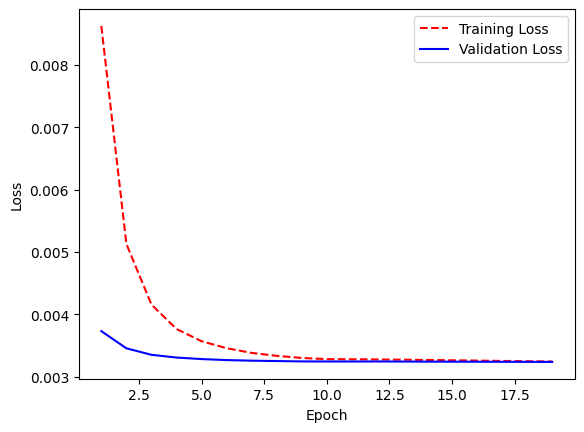

In [ ]:
plot_loss(train_loss_epoch[1:] , val_loss_epoch[1:])

In [ ]:
model = load_FDT_triplet_model(margin=0.1, device=device)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese_triplet(model, train_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9416
False Positive Rate (FPR) for threshold 0.5: 0.9447
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0602
False Positive Rate (FPR) for threshold 0.1: 0.0302
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0003
False Positive Rate (FPR) for threshold 0.01: 0.0001
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese_triplet(model, test_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9416
False Positive Rate (FPR) for threshold 0.5: 0.9447
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0602
False Positive Rate (FPR) for threshold 0.1: 0.0302
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0003
False Positive Rate (FPR) for threshold 0.01: 0.0001
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


100%|██████████| 102/102 [00:11<00:00,  8.63it/s]


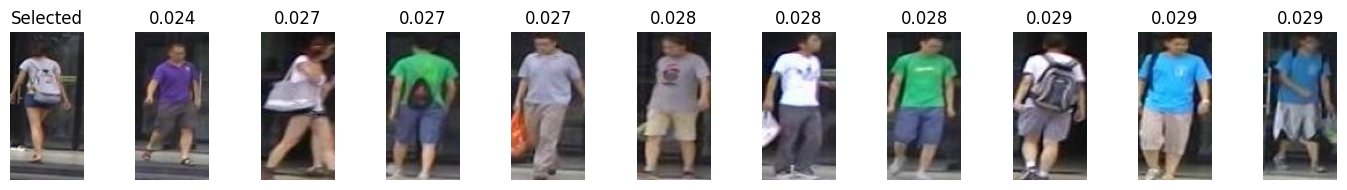

In [ ]:
get_top10_triplet(model, data_df, all_data_ds, all_data_loader, device)

### Margin = 1

In [ ]:
margin = 1

base_model = load_efficientnet_model(latent_space_dimension).to(device)
siamese_model_triplet = FDTSiameseNetworkTriplet(base_model, latent_space_dimension, feature_space_dimension).to(device)
criterion = FDTTripletLoss(margin)

optimizer = optim.Adam(siamese_model_triplet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_triplet , train_loss_epoch , val_loss_epoch = train_siamese_FDT_triplet_loss(
    siamese_model_triplet, train_loader_triplet, val_loader_triplet, criterion, optimizer, scheduler, model_config_dir, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.33it/s, Loss=10.6]


Training Epoch [1/20], Average Loss: 0.3306


Epoch 1/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.96it/s, Validation Loss=1.09]


Validation Epoch [1/20], Average Loss: 0.0346
Model saved with best validation loss: 0.0346


Epoch 2/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=1.17]


Training Epoch [2/20], Average Loss: 0.0366


Epoch 2/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.76it/s, Validation Loss=1.02]


Validation Epoch [2/20], Average Loss: 0.0323
Model saved with best validation loss: 0.0323


Epoch 3/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=1.05]


Training Epoch [3/20], Average Loss: 0.0329


Epoch 3/20 - Validation: 100%|██████████| 45/45 [00:03<00:00, 11.27it/s, Validation Loss=1.01]


Validation Epoch [3/20], Average Loss: 0.0320
Model saved with best validation loss: 0.0320


Epoch 4/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=1.03]


Training Epoch [4/20], Average Loss: 0.0321


Epoch 4/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.92it/s, Validation Loss=1]


Validation Epoch [4/20], Average Loss: 0.0319
Model saved with best validation loss: 0.0319


Epoch 5/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=1.02]


Training Epoch [5/20], Average Loss: 0.0318


Epoch 5/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.45it/s, Validation Loss=1]


Validation Epoch [5/20], Average Loss: 0.0319
Model saved with best validation loss: 0.0319


Epoch 6/20 - Training: 100%|██████████| 354/354 [01:11<00:00,  4.96it/s, Loss=1.01]


Training Epoch [6/20], Average Loss: 0.0316


Epoch 6/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.65it/s, Validation Loss=1]


Validation Epoch [6/20], Average Loss: 0.0319
Model saved with best validation loss: 0.0319


Epoch 7/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=1.01]


Training Epoch [7/20], Average Loss: 0.0315


Epoch 7/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.73it/s, Validation Loss=1]


Validation Epoch [7/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 8/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.20it/s, Loss=1.01]


Training Epoch [8/20], Average Loss: 0.0315


Epoch 8/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.20it/s, Validation Loss=1]


Validation Epoch [8/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 9/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.21it/s, Loss=1.01]


Training Epoch [9/20], Average Loss: 0.0314


Epoch 9/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.07it/s, Validation Loss=1]


Validation Epoch [9/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 10/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=1]


Training Epoch [10/20], Average Loss: 0.0314


Epoch 10/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.17it/s, Validation Loss=1]


Validation Epoch [10/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 11/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=1]


Training Epoch [11/20], Average Loss: 0.0314


Epoch 11/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.66it/s, Validation Loss=1]


Validation Epoch [11/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 12/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.29it/s, Loss=1]


Training Epoch [12/20], Average Loss: 0.0314


Epoch 12/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.53it/s, Validation Loss=1]


Validation Epoch [12/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 13/20 - Training: 100%|██████████| 354/354 [01:10<00:00,  5.04it/s, Loss=1]


Training Epoch [13/20], Average Loss: 0.0314


Epoch 13/20 - Validation: 100%|██████████| 45/45 [00:06<00:00,  6.93it/s, Validation Loss=1]


Validation Epoch [13/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 14/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=1]


Training Epoch [14/20], Average Loss: 0.0314


Epoch 14/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.22it/s, Validation Loss=1]


Validation Epoch [14/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 15/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=1]


Training Epoch [15/20], Average Loss: 0.0314


Epoch 15/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  7.98it/s, Validation Loss=1]


Validation Epoch [15/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 16/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=1]


Training Epoch [16/20], Average Loss: 0.0314


Epoch 16/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.27it/s, Validation Loss=1]


Validation Epoch [16/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 17/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=1]


Training Epoch [17/20], Average Loss: 0.0314


Epoch 17/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.59it/s, Validation Loss=1]


Validation Epoch [17/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 18/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=1]


Training Epoch [18/20], Average Loss: 0.0314


Epoch 18/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.54it/s, Validation Loss=1]


Validation Epoch [18/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 19/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.27it/s, Loss=1]


Training Epoch [19/20], Average Loss: 0.0314


Epoch 19/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.25it/s, Validation Loss=1]


Validation Epoch [19/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


Epoch 20/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=1]


Training Epoch [20/20], Average Loss: 0.0313


Epoch 20/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.56it/s, Validation Loss=1]


Validation Epoch [20/20], Average Loss: 0.0318
Model saved with best validation loss: 0.0318


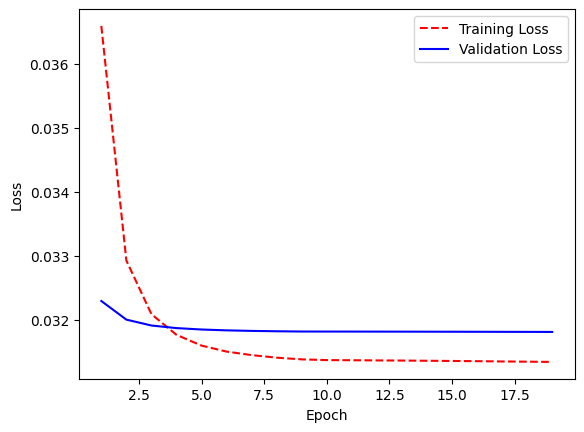

In [ ]:
plot_loss(train_loss_epoch[1:] , val_loss_epoch[1:])

In [ ]:
# model = load_FDT_triplet_model(margin=1, device=device)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_FDT_triplet_model(margin=1, device=device)
    tpr, fpr = evaluate_siamese_triplet(model, train_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9997
False Positive Rate (FPR) for threshold 0.5: 0.9999
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.4445
False Positive Rate (FPR) for threshold 0.1: 0.4688
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0005
False Positive Rate (FPR) for threshold 0.01: 0.0005
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    model = load_FDT_triplet_model(margin=1, device=device)
    tpr, fpr = evaluate_siamese_triplet(model, test_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9997
False Positive Rate (FPR) for threshold 0.5: 0.9999
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.4445
False Positive Rate (FPR) for threshold 0.1: 0.4688
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0005
False Positive Rate (FPR) for threshold 0.01: 0.0005
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0002
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


100%|██████████| 102/102 [00:11<00:00,  9.14it/s]


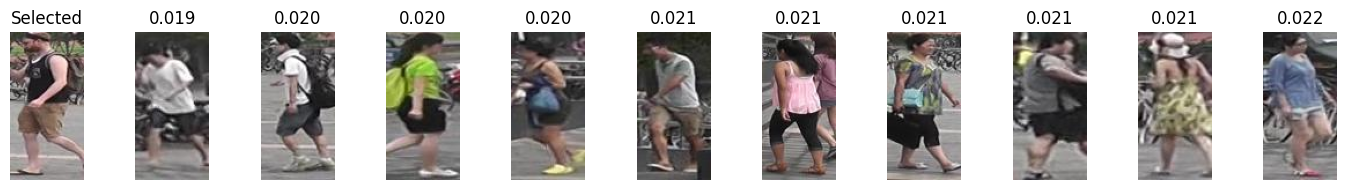

In [ ]:
get_top10_triplet(model, data_df, all_data_ds, all_data_loader, device)

### Margin = 10

In [ ]:
margin = 10

base_model = load_efficientnet_model(latent_space_dimension).to(device)
siamese_model_triplet = FDTSiameseNetworkTriplet(base_model, latent_space_dimension, feature_space_dimension).to(device)
criterion = FDTTripletLoss(margin)

optimizer = optim.Adam(siamese_model_triplet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

siamese_model_triplet , train_loss_epoch , val_loss_epoch = train_siamese_FDT_triplet_loss(
    siamese_model_triplet, train_loader_triplet, val_loader_triplet, criterion, optimizer, scheduler, model_config_dir, margin, num_epochs
)

Epoch 1/20 - Training: 100%|██████████| 354/354 [01:10<00:00,  5.00it/s, Loss=19.4]


Training Epoch [1/20], Average Loss: 0.6066


Epoch 1/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.85it/s, Validation Loss=10.1]


Validation Epoch [1/20], Average Loss: 0.3195
Model saved with best validation loss: 0.3195


Epoch 2/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.29it/s, Loss=10.2]


Training Epoch [2/20], Average Loss: 0.3178


Epoch 2/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.47it/s, Validation Loss=10]


Validation Epoch [2/20], Average Loss: 0.3180
Model saved with best validation loss: 0.3180


Epoch 3/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.30it/s, Loss=10.1]


Training Epoch [3/20], Average Loss: 0.3143


Epoch 3/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.20it/s, Validation Loss=10]


Validation Epoch [3/20], Average Loss: 0.3178
Model saved with best validation loss: 0.3178


Epoch 4/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.32it/s, Loss=10]


Training Epoch [4/20], Average Loss: 0.3134


Epoch 4/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.49it/s, Validation Loss=10]


Validation Epoch [4/20], Average Loss: 0.3177
Model saved with best validation loss: 0.3177


Epoch 5/20 - Training: 100%|██████████| 354/354 [01:06<00:00,  5.32it/s, Loss=10]


Training Epoch [5/20], Average Loss: 0.3130


Epoch 5/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.96it/s, Validation Loss=10]


Validation Epoch [5/20], Average Loss: 0.3177
Model saved with best validation loss: 0.3177


Epoch 6/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=10]


Training Epoch [6/20], Average Loss: 0.3129


Epoch 6/20 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.76it/s, Validation Loss=10]


Validation Epoch [6/20], Average Loss: 0.3177
Model saved with best validation loss: 0.3177


Epoch 7/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s, Loss=10]


Training Epoch [7/20], Average Loss: 0.3128


Epoch 7/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.46it/s, Validation Loss=10]


Validation Epoch [7/20], Average Loss: 0.3177
Model saved with best validation loss: 0.3177


Epoch 8/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.20it/s, Loss=10]


Training Epoch [8/20], Average Loss: 0.3127


Epoch 8/20 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.66it/s, Validation Loss=10]


Validation Epoch [8/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 9/20 - Training: 100%|██████████| 354/354 [01:13<00:00,  4.80it/s, Loss=10]


Training Epoch [9/20], Average Loss: 0.3127


Epoch 9/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.06it/s, Validation Loss=10]


Validation Epoch [9/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 10/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.20it/s, Loss=10]


Training Epoch [10/20], Average Loss: 0.3126


Epoch 10/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.59it/s, Validation Loss=10]


Validation Epoch [10/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 11/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.19it/s, Loss=10]


Training Epoch [11/20], Average Loss: 0.3126


Epoch 11/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.08it/s, Validation Loss=10]


Validation Epoch [11/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 12/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.19it/s, Loss=10]


Training Epoch [12/20], Average Loss: 0.3126


Epoch 12/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.06it/s, Validation Loss=10]


Validation Epoch [12/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 13/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=10]


Training Epoch [13/20], Average Loss: 0.3126


Epoch 13/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.78it/s, Validation Loss=10]


Validation Epoch [13/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 14/20 - Training: 100%|██████████| 354/354 [01:08<00:00,  5.17it/s, Loss=10]


Training Epoch [14/20], Average Loss: 0.3126


Epoch 14/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.79it/s, Validation Loss=10]


Validation Epoch [14/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 15/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=10]


Training Epoch [15/20], Average Loss: 0.3126


Epoch 15/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.10it/s, Validation Loss=10]


Validation Epoch [15/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 16/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s, Loss=10]


Training Epoch [16/20], Average Loss: 0.3126


Epoch 16/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s, Validation Loss=10]


Validation Epoch [16/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 17/20 - Training: 100%|██████████| 354/354 [01:12<00:00,  4.87it/s, Loss=10]


Training Epoch [17/20], Average Loss: 0.3126


Epoch 17/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.94it/s, Validation Loss=10]


Validation Epoch [17/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 18/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=10]


Training Epoch [18/20], Average Loss: 0.3126


Epoch 18/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.97it/s, Validation Loss=10]


Validation Epoch [18/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 19/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s, Loss=10]


Training Epoch [19/20], Average Loss: 0.3126


Epoch 19/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.08it/s, Validation Loss=10]


Validation Epoch [19/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


Epoch 20/20 - Training: 100%|██████████| 354/354 [01:07<00:00,  5.24it/s, Loss=10]


Training Epoch [20/20], Average Loss: 0.3126


Epoch 20/20 - Validation: 100%|██████████| 45/45 [00:04<00:00, 11.14it/s, Validation Loss=10]


Validation Epoch [20/20], Average Loss: 0.3176
Model saved with best validation loss: 0.3176


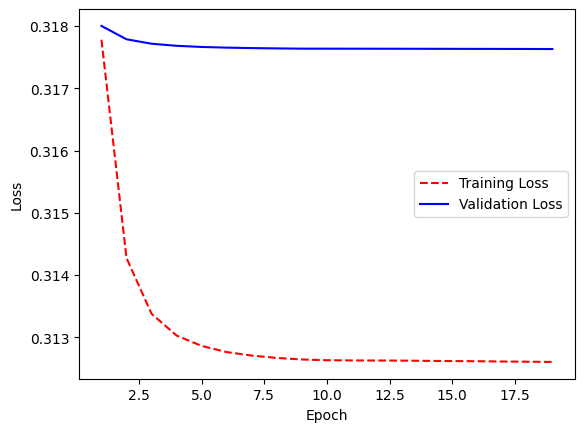

In [ ]:
plot_loss(train_loss_epoch[1:] , val_loss_epoch[1:])

In [ ]:
model = load_FDT_triplet_model(margin=10, device=device)

In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese_triplet(model, train_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9394
False Positive Rate (FPR) for threshold 0.5: 0.9998
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0070
False Positive Rate (FPR) for threshold 0.1: 0.1458
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0001
False Positive Rate (FPR) for threshold 0.01: 0.0004
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


In [ ]:
for thresh in [0.5,0.1,0.01,0.001]:
    tpr, fpr = evaluate_siamese_triplet(model, test_loader_triplet , threshold = thresh)
    print(f'True Positive Rate (TPR) for threshold {thresh}: {tpr:.4f}')
    print(f'False Positive Rate (FPR) for threshold {thresh}: {fpr:.4f}')
    print("*********************************")

True Positive Rate (TPR) for threshold 0.5: 0.9394
False Positive Rate (FPR) for threshold 0.5: 0.9998
*********************************
True Positive Rate (TPR) for threshold 0.1: 0.0070
False Positive Rate (FPR) for threshold 0.1: 0.1458
*********************************
True Positive Rate (TPR) for threshold 0.01: 0.0001
False Positive Rate (FPR) for threshold 0.01: 0.0004
*********************************
True Positive Rate (TPR) for threshold 0.001: 0.0001
False Positive Rate (FPR) for threshold 0.001: 0.0001
*********************************


100%|██████████| 102/102 [00:11<00:00,  8.73it/s]


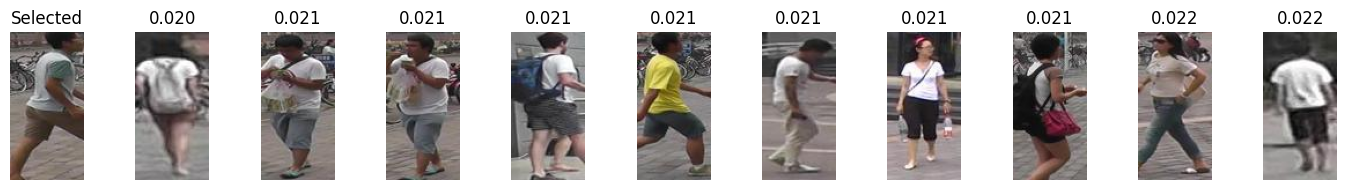

In [ ]:
get_top10_triplet(model, data_df, all_data_ds, all_data_loader, device)